### Importing Necessary Libraries & Dependencies

In [1]:
! pip install torchsummary
! pip install torch-lr-finder

In [3]:
!pip install idx2numpy

  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7904 sha256=6ea9cc01c5721458c444b17506fb36a203b42c6e5b212deb02d2c602839f563c
  Stored in directory: /root/.cache/pip/wheels/e0/f4/e7/643fc5f932ec2ff92997f43f007660feb23f948aa8486f1107
Successfully built idx2numpy


In [7]:
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, datasets
from torchvision.transforms import functional as TF
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch_lr_finder import LRFinder
from torchsummary import summary
from PIL import Image

import numpy as np
import pandas as pd
import idx2numpy
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import os

from tqdm.autonotebook import tqdm
import warnings
warnings.filterwarnings("ignore")

### Loading the Dataset

In [8]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, img_dir, label_mapping, transform=None):
        
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_mapping = label_mapping
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load image
        img_name = os.path.join(self.img_dir, self.data.iloc[idx, 0])  # Assuming filenames are in the first column
        image = Image.open(img_name).convert("RGB")

        # Map label to integer
        label_str = self.data.iloc[idx, 1]  # Assuming labels are in the second column
        label = self.label_mapping[label_str]

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        return image, label

In [9]:
label_mapping = {"dog": 0, "cat": 1, "bird": 2}

# image labels csv file and training dataset directories
csv_file = '/kaggle/input/dog-vs-cat-vs-bird/dataset/train.csv'
root_dir = '/kaggle/input/dog-vs-cat-vs-bird/dataset/train'

# importing all images
dataset = CustomDataset(csv_file=csv_file, img_dir=root_dir, label_mapping=label_mapping, transform=None)

In [10]:
# confirming image dimensions by selecting an image file from the directory
sample_image_path = os.path.join(root_dir, os.listdir(root_dir)[0])

# open the image
with Image.open(sample_image_path) as img:
    width, height = img.size
    print(f"Image dimensions: {width}x{height} pixels")

Image dimensions: 32x32 pixels


### Train-Val Split

In [11]:
# split into train and validation sets
train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)

# creating Subsets
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

### Applying Transformations

In [12]:
# transformations to training set: data augmentation, resizing, normalization
train_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomRotation(45), # augmentation 1: rotation by 45 degrees
    transforms.RandomHorizontalFlip(), # augmentation 2: rotate horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), # augmentation 3: color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# transformations to validation set: resizing, normalization
val_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# applying transformations to datasets
train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_transforms

In [13]:
# printing training and validation size
print("Training Dataset:", len(train_dataset))
print("Validation Dataset:", len(val_dataset))

Training Dataset: 9600
Validation Dataset: 2400


In [14]:
# defining data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [15]:
for images, labels in train_loader:
    print(images.shape)
    print(labels)
    break

# for reference:
# dog = 0, cat = 1, bird = 2

torch.Size([32, 3, 32, 32])
tensor([2, 2, 1, 0, 0, 0, 2, 0, 2, 0, 2, 1, 0, 2, 0, 0, 2, 2, 0, 2, 2, 2, 0, 1,
        1, 2, 1, 2, 1, 0, 1, 1])


### Visualizing Sample Training Images

In [16]:
# visualizing images using a denormalizing function
def denormalize(image, mean, std):
    mean = np.array(mean)
    std = np.array(std)
    image = image.numpy().transpose((1, 2, 0))  # Convert from CHW to HWC
    image = std * image + mean  # Undo normalization
    image = np.clip(image, 0, 1)  # Clip values to [0, 1] range
    return image

In [17]:
# visualizing a batch of images with mapped labels
def visualize_images(loader, mean, std, title, label_mapping, num_images=8):
    images, labels = next(iter(loader))  # Get a batch of images
    images = images[:num_images]  # Select a subset of images
    labels = labels[:num_images]  # Select corresponding labels
    
    # Reverse the label mapping to get string labels
    reverse_mapping = {v: k for k, v in label_mapping.items()}
    
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        img = denormalize(images[i], mean, std)  # Denormalize the image
        plt.imshow(img)
        
        # Map the integer label to its string label
        string_label = reverse_mapping[labels[i].item()]  # Convert tensor to int
        
        plt.title(f"Label: {string_label}")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

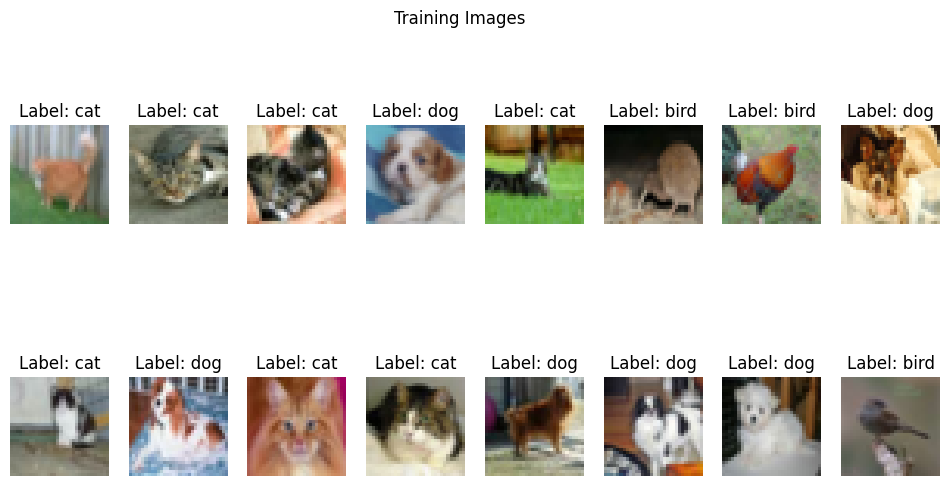

In [18]:
mean = [0.5, 0.5, 0.5]  # Same as normalization mean
std = [0.5, 0.5, 0.5]  # Same as normalization std

# visualizing training images
visualize_images(train_loader, mean, std, "Training Images", label_mapping, num_images=16)

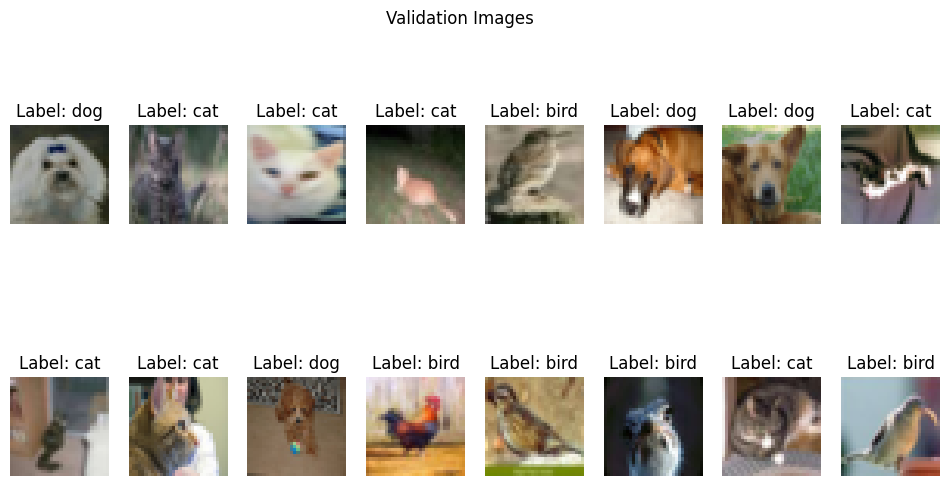

In [19]:
# visualizing validation images
visualize_images(val_loader, mean, std, "Validation Images", label_mapping, num_images=16)

The labels are correctly set for both, training and validation sets.

### Experimentations

### VGG16

In [22]:
# loading the pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# freezing all the parameters so we can only train the final layer
for param in model.parameters():
    param.requires_grad = False

# modify the classifier layer for our specific task (3 classes: dog, cat, bird)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 3)

# defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

# early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0

# training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # training step
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {100*correct/total}%")

    # evaluating on the validation set to check for early stopping
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss}, Validation Accuracy: {100 * correct_val / total_val}%")

    # early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset the counter since validation loss improved
        # saving the best model so far
        torch.save(model.state_dict(), "vgg16_dog_cat_bird_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
            break

# evaluating the model on the validation set after training
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Validation Accuracy: {100 * correct / total}%")

Epoch 1/50, Loss: 0.9001511993010839, Accuracy: 63.9375%
Validation Loss: 0.7705245125293732, Validation Accuracy: 67.33333333333333%
Epoch 2/50, Loss: 0.8746007777253787, Accuracy: 66.57291666666667%
Validation Loss: 0.7237981990973155, Validation Accuracy: 68.29166666666667%
Epoch 3/50, Loss: 0.8694587361812591, Accuracy: 66.80208333333333%
Validation Loss: 0.7639012821515401, Validation Accuracy: 68.45833333333333%
Epoch 4/50, Loss: 0.8773827743530274, Accuracy: 66.46875%
Validation Loss: 0.7479943990707397, Validation Accuracy: 69.66666666666667%
Epoch 5/50, Loss: 0.8894511806964874, Accuracy: 67.29166666666667%
Validation Loss: 0.7363899226983388, Validation Accuracy: 68.5%
Epoch 6/50, Loss: 0.8750917302568754, Accuracy: 68.0%
Validation Loss: 0.7663790150483449, Validation Accuracy: 68.375%
Epoch 7/50, Loss: 0.8778877910971642, Accuracy: 67.83333333333333%
Validation Loss: 0.7488238298892975, Validation Accuracy: 68.5%
Early stopping triggered. Stopping training at epoch 7.
Final

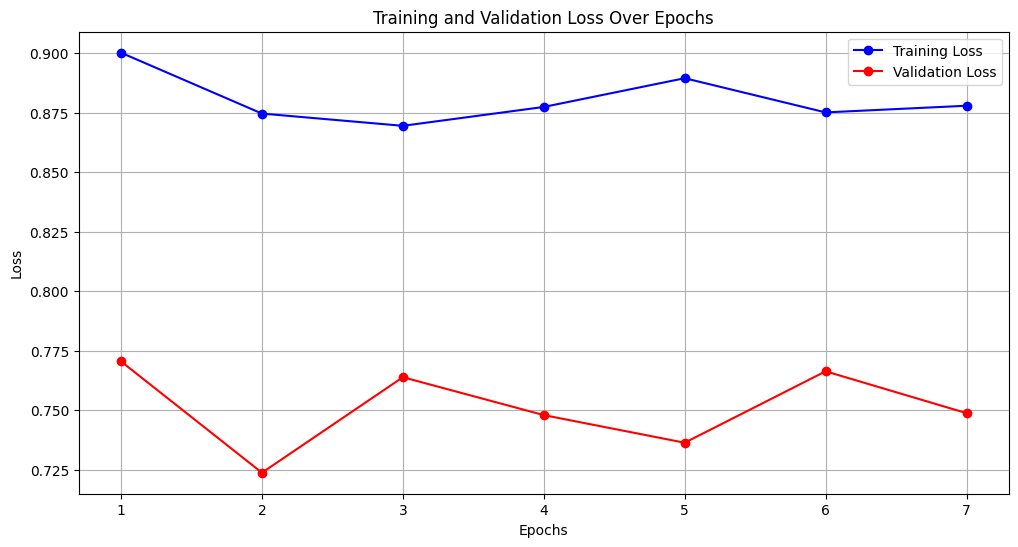

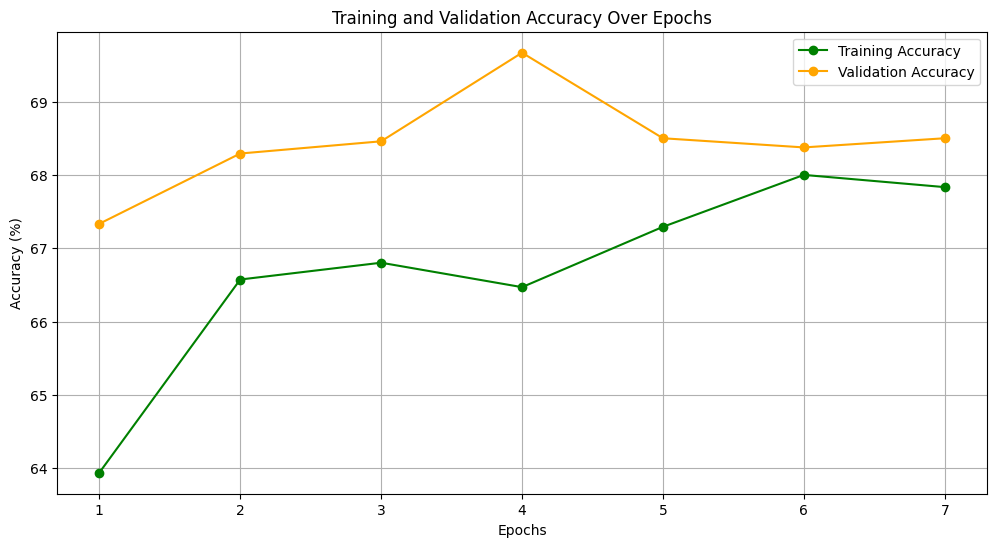

In [54]:
epochs = list(range(1, 8))

train_loss = [
    0.9001511993010839, 0.8746007777253787, 0.8694587361812591, 
    0.8773827743530274, 0.8894511806964874, 0.8750917302568754, 
    0.8778877910971642
]

val_loss = [
    0.7705245125293732, 0.7237981990973155, 0.7639012821515401, 
    0.7479943990707397, 0.7363899226983388, 0.7663790150483449, 
    0.7488238298892975
]

train_acc = [
    63.9375, 66.57291666666667, 66.80208333333333, 
    66.46875, 67.29166666666667, 68.0, 
    67.83333333333333
]

val_acc = [
    67.33333333333333, 68.29166666666667, 68.45833333333333, 
    69.66666666666667, 68.5, 68.375, 
    68.5
]

# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', color='green', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

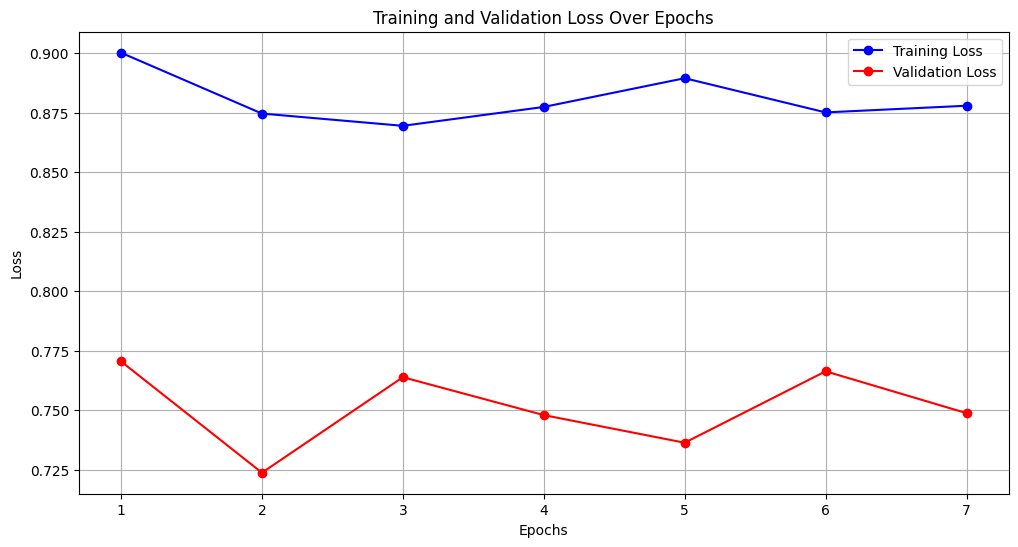

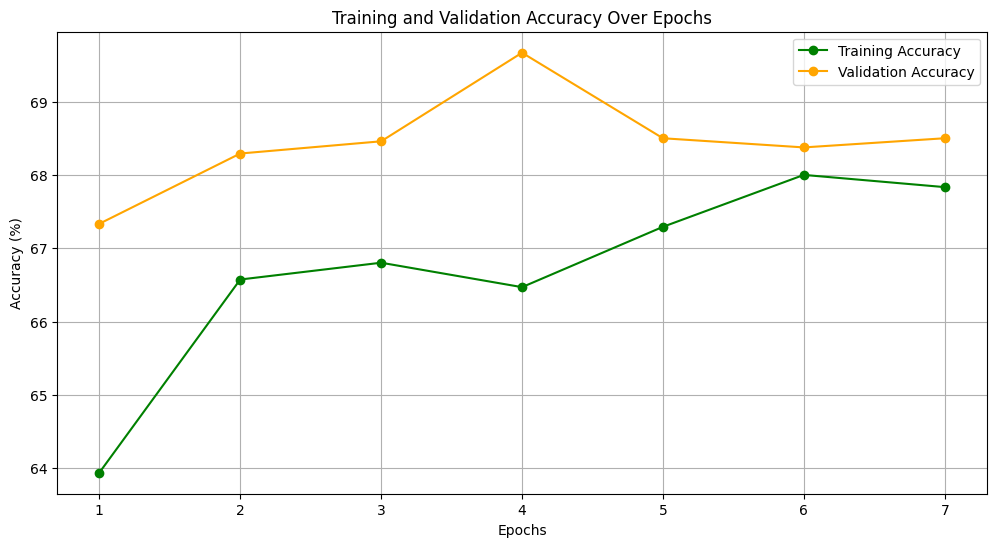

In [53]:
epochs = list(range(1, 8))

train_loss = [
    0.9001511993010839, 0.8746007777253787, 0.8694587361812591, 
    0.8773827743530274, 0.8894511806964874, 0.8750917302568754, 
    0.8778877910971642
]

val_loss = [
    0.7705245125293732, 0.7237981990973155, 0.7639012821515401, 
    0.7479943990707397, 0.7363899226983388, 0.7663790150483449, 
    0.7488238298892975
]

train_acc = [
    63.9375, 66.57291666666667, 66.80208333333333, 
    66.46875, 67.29166666666667, 68.0, 
    67.83333333333333
]

val_acc = [
    67.33333333333333, 68.29166666666667, 68.45833333333333, 
    69.66666666666667, 68.5, 68.375, 
    68.5
]

# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', color='green', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

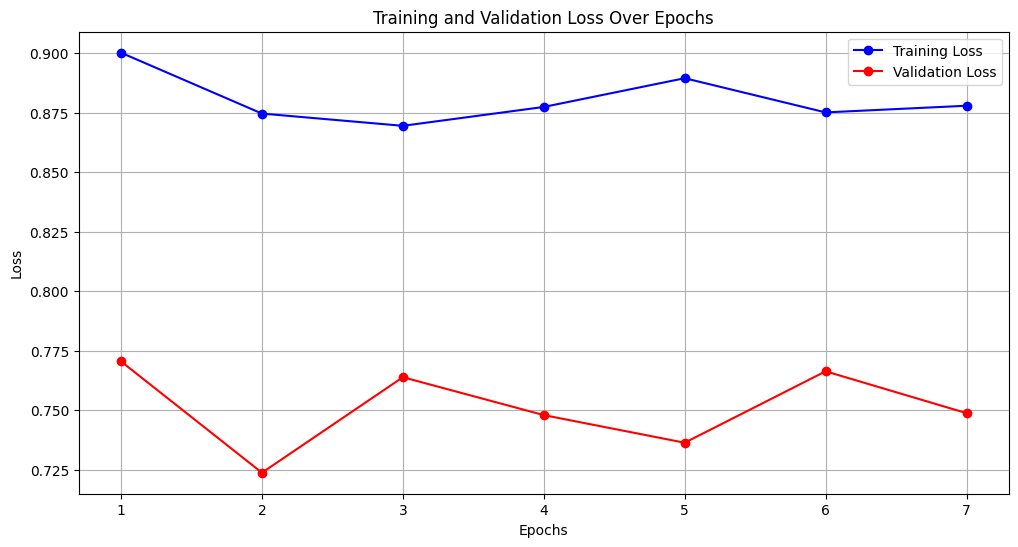

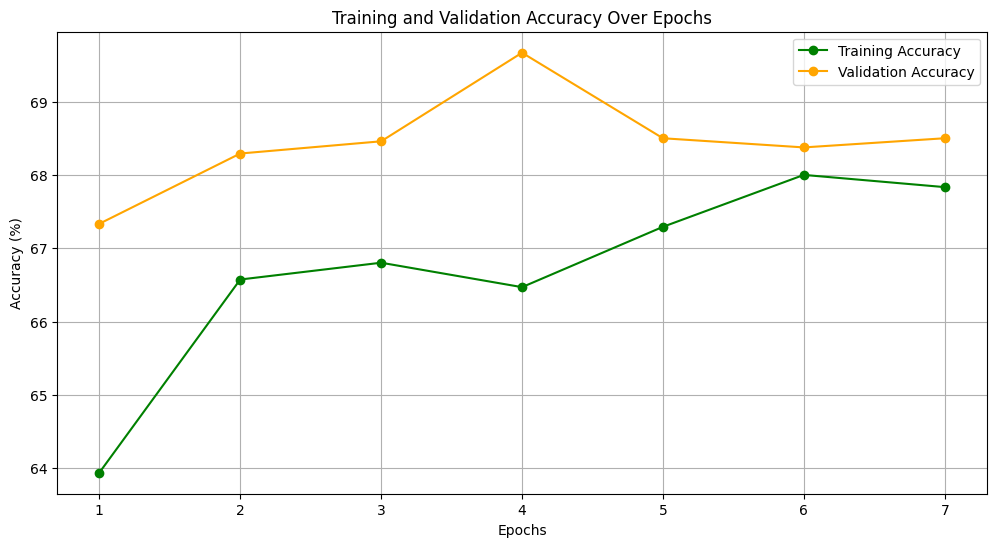

In [52]:
epochs = list(range(1, 8))

train_loss = [
    0.9001511993010839, 0.8746007777253787, 0.8694587361812591, 
    0.8773827743530274, 0.8894511806964874, 0.8750917302568754, 
    0.8778877910971642
]

val_loss = [
    0.7705245125293732, 0.7237981990973155, 0.7639012821515401, 
    0.7479943990707397, 0.7363899226983388, 0.7663790150483449, 
    0.7488238298892975
]

train_acc = [
    63.9375, 66.57291666666667, 66.80208333333333, 
    66.46875, 67.29166666666667, 68.0, 
    67.83333333333333
]

val_acc = [
    67.33333333333333, 68.29166666666667, 68.45833333333333, 
    69.66666666666667, 68.5, 68.375, 
    68.5
]

# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', color='green', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### VGG16 (Cosine Annealing)

In [23]:
# loading the pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# freezing all the parameters so we can only train the final layer
for param in model.parameters():
    param.requires_grad = False

# modify the classifier layer for our specific task (3 classes: dog, cat, bird)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 3)

# defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

# Cosine Annealing scheduler (with max learning rate and number of epochs)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0

# training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # training step
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {100*correct/total}%")

    # evaluating on the validation set to check for early stopping
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss}, Validation Accuracy: {100 * correct_val / total_val}%")

    # early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset the counter since validation loss improved
        # saving the best model so far
        torch.save(model.state_dict(), "vgg16_dog_cat_bird_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
            break

    # updating the learning rate using Cosine Annealing Scheduler
    scheduler.step()

# evaluating the model on the validation set after training
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Validation Accuracy: {100 * correct / total}%")

Epoch 1/50, Loss: 0.8883858565489451, Accuracy: 63.125%
Validation Loss: 0.7639587704340617, Validation Accuracy: 69.125%
Epoch 2/50, Loss: 0.8854013367493947, Accuracy: 65.54166666666667%
Validation Loss: 0.7627159690856934, Validation Accuracy: 68.20833333333333%
Epoch 3/50, Loss: 0.8785881050427755, Accuracy: 66.59375%
Validation Loss: 0.730641421477, Validation Accuracy: 69.625%
Epoch 4/50, Loss: 0.890046941836675, Accuracy: 66.38541666666667%
Validation Loss: 0.7323854875564575, Validation Accuracy: 68.79166666666667%
Epoch 5/50, Loss: 0.9052574792504311, Accuracy: 66.625%
Validation Loss: 0.7451271100838979, Validation Accuracy: 67.95833333333333%
Epoch 6/50, Loss: 0.8789461786548297, Accuracy: 66.84375%
Validation Loss: 0.802130496899287, Validation Accuracy: 69.33333333333333%
Epoch 7/50, Loss: 0.8816723972558975, Accuracy: 67.39583333333333%
Validation Loss: 0.7580649328231811, Validation Accuracy: 68.75%
Epoch 8/50, Loss: 0.8623971952994665, Accuracy: 67.77083333333333%
Valid

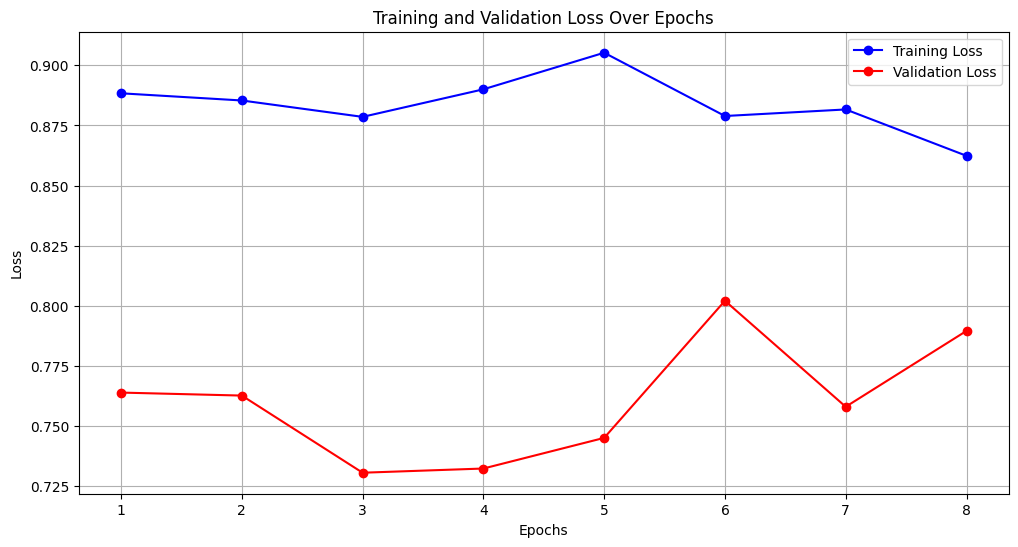

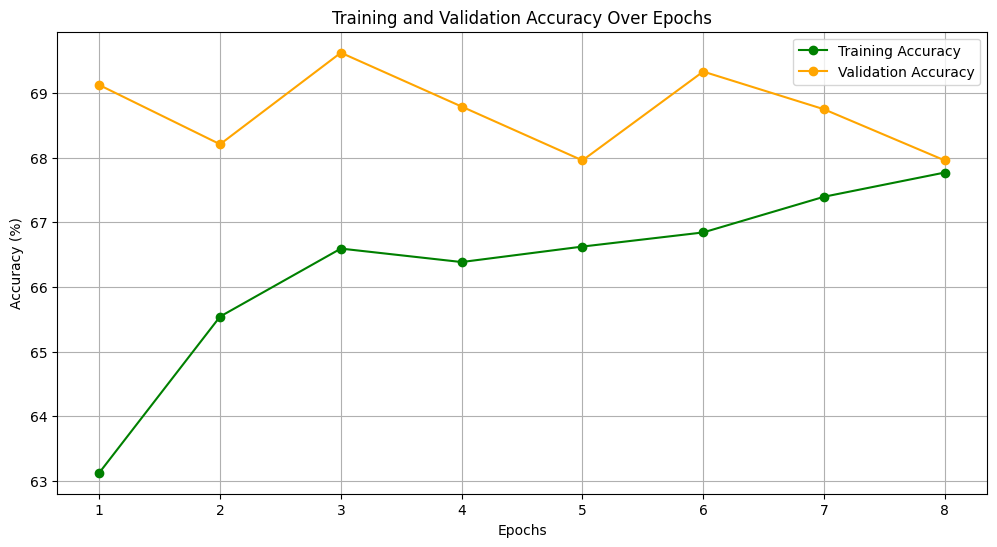

In [51]:
epochs = list(range(1, 9))

train_loss = [
    0.8883858565489451, 0.8854013367493947, 0.8785881050427755, 
    0.890046941836675, 0.9052574792504311, 0.8789461786548297, 
    0.8816723972558975, 0.8623971952994665
]

val_loss = [
    0.7639587704340617, 0.7627159690856934, 0.730641421477, 
    0.7323854875564575, 0.7451271100838979, 0.802130496899287, 
    0.7580649328231811, 0.7896068759759267
]

train_acc = [
    63.125, 65.54166666666667, 66.59375, 
    66.38541666666667, 66.625, 66.84375, 
    67.39583333333333, 67.77083333333333
]

val_acc = [
    69.125, 68.20833333333333, 69.625, 
    68.79166666666667, 67.95833333333333, 69.33333333333333, 
    68.75, 67.95833333333333
]

# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', color='green', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### VGG16 (ADAM)

In [36]:
# loading the pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# freezing all the parameters so we can only train the final layer
for param in model.parameters():
    param.requires_grad = False

# modifying the classifier layer for our specific task (3 classes: dog, cat, bird)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 3)

# removing Dropout (no Dropout layers in the classifier)
model.classifier = nn.Sequential(
    model.classifier[0],
    model.classifier[1],
    model.classifier[3],
    model.classifier[4],
    model.classifier[6]
)

# defining the loss function
criterion = nn.CrossEntropyLoss()

# defining the optimizer with Adam (removed weight decay for regularization)
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

# Cosine Annealing scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0

# training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # training step
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {100*correct/total}%")

    # evaluating on the validation set to check for early stopping
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss}, Validation Accuracy: {100 * correct_val / total_val}%")

    # early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset the counter since validation loss improved
        # Save the best model so far
        torch.save(model.state_dict(), "vgg16_dog_cat_bird_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
            break

    # updating the learning rate using Cosine Annealing Scheduler
    scheduler.step()

# evaluating the model on the validation set after training
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Validation Accuracy: {100 * correct / total}%")

Epoch 1/50, Loss: 0.7622570781906446, Accuracy: 67.27083333333333%
Validation Loss: 0.7289830040931702, Validation Accuracy: 68.875%
Epoch 2/50, Loss: 0.5994218336542447, Accuracy: 74.65625%
Validation Loss: 0.744315702120463, Validation Accuracy: 69.41666666666667%
Epoch 3/50, Loss: 0.5516582883397738, Accuracy: 77.47916666666667%
Validation Loss: 0.7578486347198486, Validation Accuracy: 68.25%
Epoch 4/50, Loss: 0.49818464522560435, Accuracy: 79.14583333333333%
Validation Loss: 0.7757342223326366, Validation Accuracy: 69.125%
Epoch 5/50, Loss: 0.46002130592862767, Accuracy: 80.73958333333333%
Validation Loss: 0.7783024700482687, Validation Accuracy: 70.0%
Epoch 6/50, Loss: 0.43175191774964333, Accuracy: 82.125%
Validation Loss: 0.8126336467266083, Validation Accuracy: 68.83333333333333%
Early stopping triggered. Stopping training at epoch 6.
Final Validation Accuracy: 68.83333333333333%


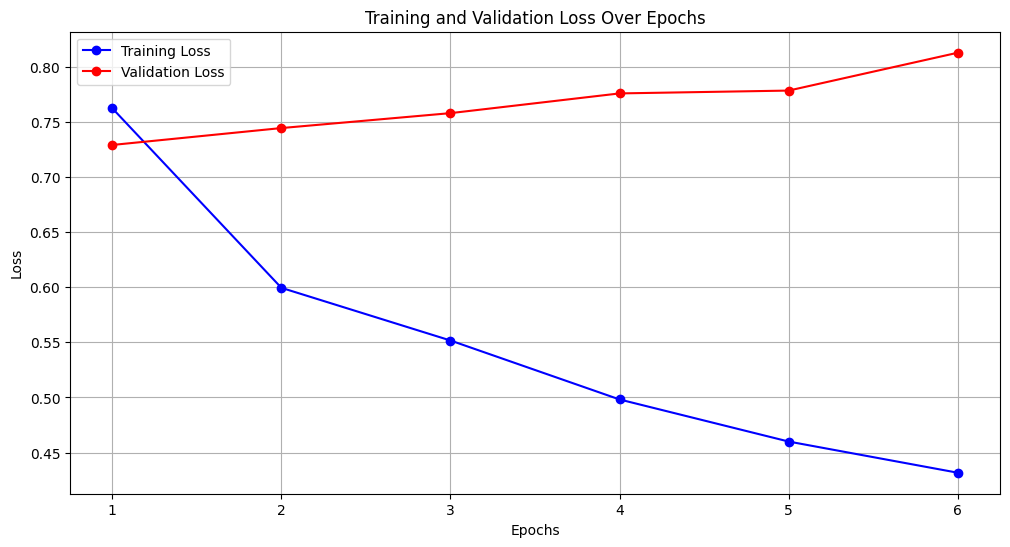

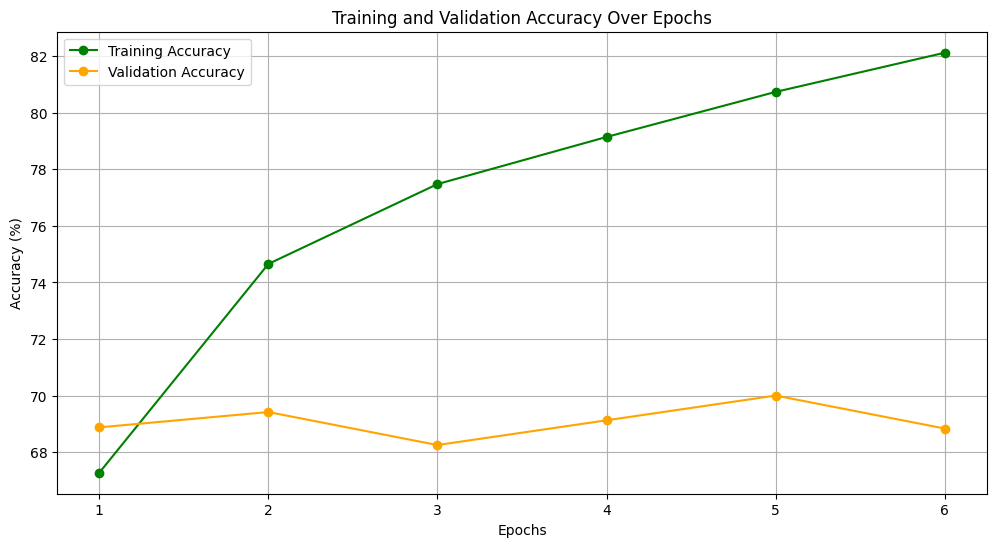

In [55]:
epochs = list(range(1, 7))

train_loss = [
    0.7622570781906446, 0.5994218336542447, 0.5516582883397738,
    0.49818464522560435, 0.46002130592862767, 0.43175191774964333
]

val_loss = [
    0.7289830040931702, 0.744315702120463, 0.7578486347198486,
    0.7757342223326366, 0.7783024700482687, 0.8126336467266083
]

train_acc = [
    67.27083333333333, 74.65625, 77.47916666666667,
    79.14583333333333, 80.73958333333333, 82.125
]

val_acc = [
    68.875, 69.41666666666667, 68.25,
    69.125, 70.0, 68.83333333333333
]

# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', color='green', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### VGG16 (ADAM + 50% Dropouts)

In [35]:
# loading the pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# freezing all the parameters so we can only train the final layer
for param in model.parameters():
    param.requires_grad = False

# modifying the classifier layer for our specific task (3 classes: dog, cat, bird)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 3)

# adding Dropout to the classifier (removed Batch Normalization)
model.classifier = nn.Sequential(
    model.classifier[0],  # 4096 input features, no change here
    model.classifier[1],  # ReLU activation
    nn.Dropout(0.5),  # Dropout with 50% probability
    model.classifier[3],  # Second FC layer
    model.classifier[4],  # ReLU activation
    nn.Dropout(0.5),  # Dropout after the second FC layer
    model.classifier[6]  # The final output layer (3 classes)
)

# defining the loss function
criterion = nn.CrossEntropyLoss()

# defining the optimizer with Adam
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

# Cosine Annealing scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0

# training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # training step
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {100*correct/total}%")

    # evaluating on the validation set to check for early stopping
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss}, Validation Accuracy: {100 * correct_val / total_val}%")

    # early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset the counter since validation loss improved
        # Save the best model so far
        torch.save(model.state_dict(), "vgg16_dog_cat_bird_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
            break

    # updating the learning rate using Cosine Annealing Scheduler
    scheduler.step()

# evaluating the model on the validation set after training
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Validation Accuracy: {100 * correct / total}%")

Epoch 1/50, Loss: 0.9070002661148707, Accuracy: 63.625%
Validation Loss: 0.714117972056071, Validation Accuracy: 69.375%
Epoch 2/50, Loss: 0.8701600955923399, Accuracy: 66.20833333333333%
Validation Loss: 0.7559170325597128, Validation Accuracy: 67.625%
Epoch 3/50, Loss: 0.8789797027905782, Accuracy: 67.13541666666667%
Validation Loss: 0.7528990999857584, Validation Accuracy: 68.5%
Epoch 4/50, Loss: 0.8964158955216408, Accuracy: 66.34375%
Validation Loss: 0.7416010018189748, Validation Accuracy: 68.66666666666667%
Epoch 5/50, Loss: 0.8741821827491124, Accuracy: 67.23958333333333%
Validation Loss: 0.7508152163028717, Validation Accuracy: 69.0%
Epoch 6/50, Loss: 0.8732958604892095, Accuracy: 67.42708333333333%
Validation Loss: 0.7350093845526378, Validation Accuracy: 69.54166666666667%
Early stopping triggered. Stopping training at epoch 6.
Final Validation Accuracy: 69.54166666666667%


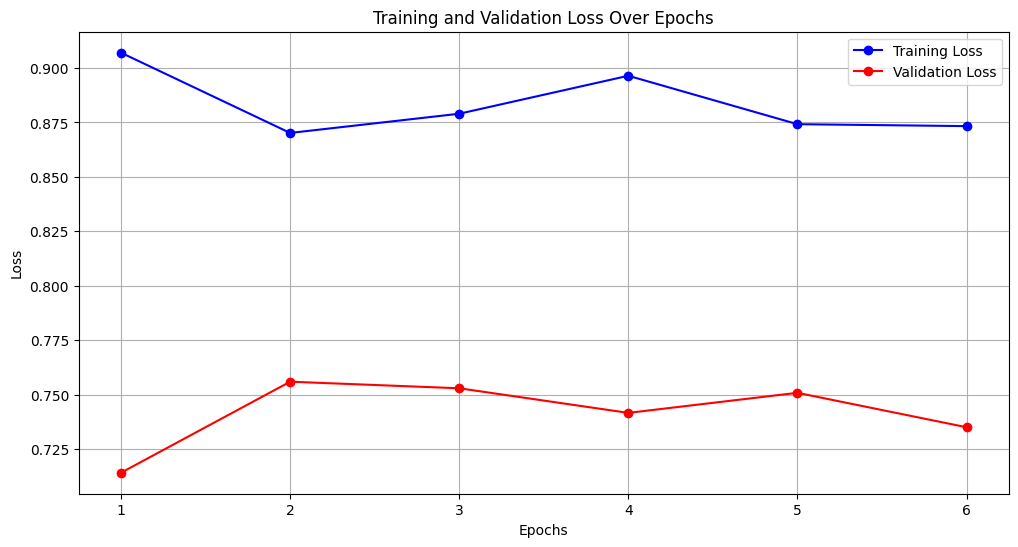

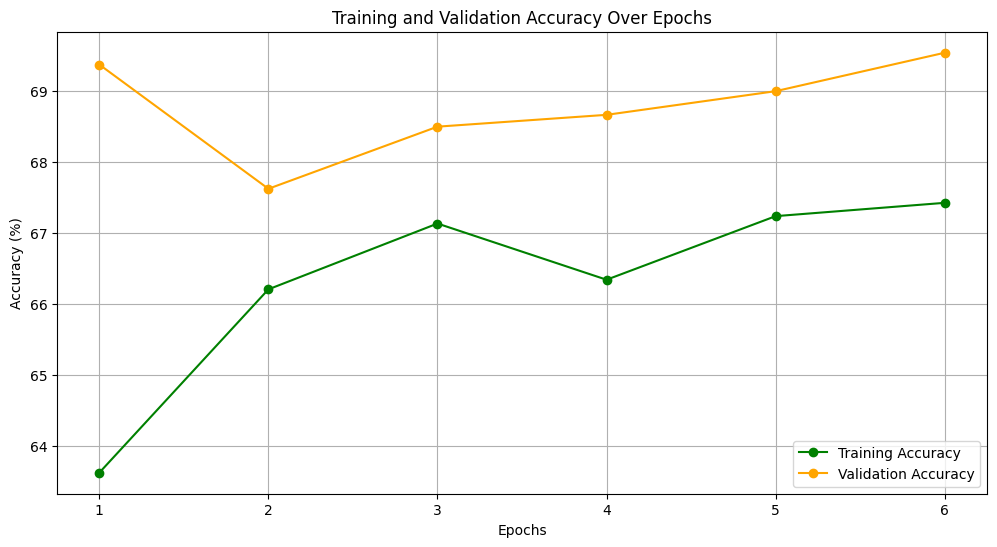

In [56]:
epochs = list(range(1, 7))

train_loss = [
    0.9070002661148707, 0.8701600955923399, 0.8789797027905782,
    0.8964158955216408, 0.8741821827491124, 0.8732958604892095
]

val_loss = [
    0.714117972056071, 0.7559170325597128, 0.7528990999857584,
    0.7416010018189748, 0.7508152163028717, 0.7350093845526378
]

train_acc = [
    63.625, 66.20833333333333, 67.13541666666667,
    66.34375, 67.23958333333333, 67.42708333333333
]

val_acc = [
    69.375, 67.625, 68.5,
    68.66666666666667, 69.0, 69.54166666666667
]

# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', color='green', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### VGG16 (ADAM + 30% Dropouts)

In [34]:
# loading the pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# freezing all the parameters so we can only train the final layer
for param in model.parameters():
    param.requires_grad = False

# modifying the classifier layer
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 3)

# adding Dropout to the classifier
model.classifier = nn.Sequential(
    model.classifier[0],
    model.classifier[1],
    nn.Dropout(0.3),
    model.classifier[3],
    model.classifier[4],
    nn.Dropout(0.3),
    model.classifier[6]
)

# defining the loss function
criterion = nn.CrossEntropyLoss()

# defining the optimizer with Adam
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

# Cosine Annealing scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0

# training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # training step
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {100*correct/total}%")

    # evaluating on the validation set to check for early stopping
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss}, Validation Accuracy: {100 * correct_val / total_val}%")

    # early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset the counter since validation loss improved
        # Save the best model so far
        torch.save(model.state_dict(), "vgg16_dog_cat_bird_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
            break

    # updating the learning rate using Cosine Annealing Scheduler
    scheduler.step()

# evaluating the model on the validation set after training
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Validation Accuracy: {100 * correct / total}%")

Epoch 1/50, Loss: 0.8118341407179832, Accuracy: 66.10416666666667%
Validation Loss: 0.7557618467013041, Validation Accuracy: 68.5%
Epoch 2/50, Loss: 0.7475734608372052, Accuracy: 69.19791666666667%
Validation Loss: 0.7199077733357747, Validation Accuracy: 69.45833333333333%
Epoch 3/50, Loss: 0.7142591155568758, Accuracy: 70.91666666666667%
Validation Loss: 0.7882109181086222, Validation Accuracy: 68.33333333333333%
Epoch 4/50, Loss: 0.6992513253291448, Accuracy: 71.625%
Validation Loss: 0.7668063692251841, Validation Accuracy: 67.91666666666667%
Epoch 5/50, Loss: 0.698446586082379, Accuracy: 71.64583333333333%
Validation Loss: 0.7578653045495352, Validation Accuracy: 68.875%
Epoch 6/50, Loss: 0.7089028457800547, Accuracy: 71.66666666666667%
Validation Loss: 0.7662060678005218, Validation Accuracy: 69.58333333333333%
Epoch 7/50, Loss: 0.7095555138091246, Accuracy: 72.07291666666667%
Validation Loss: 0.7671362678209941, Validation Accuracy: 68.375%
Early stopping triggered. Stopping trai

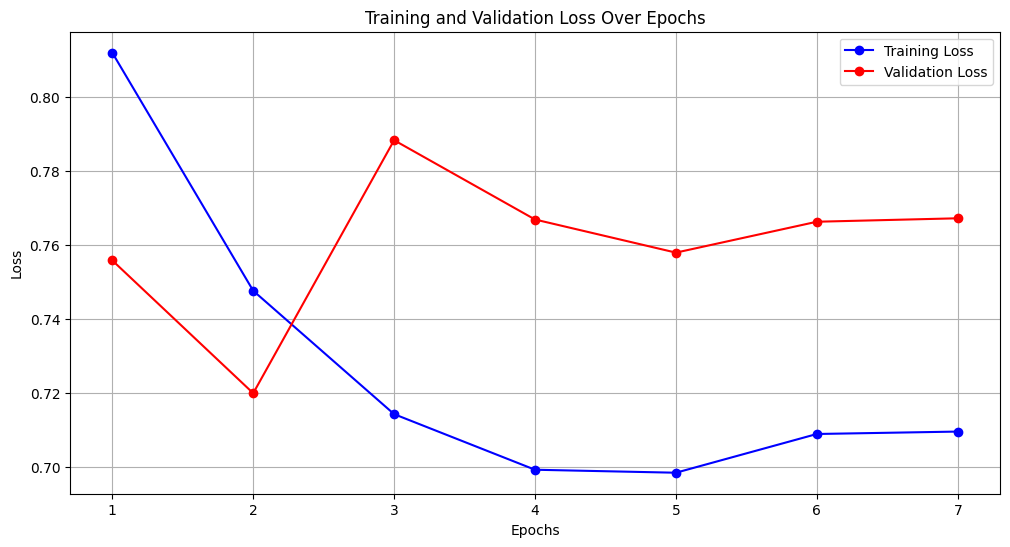

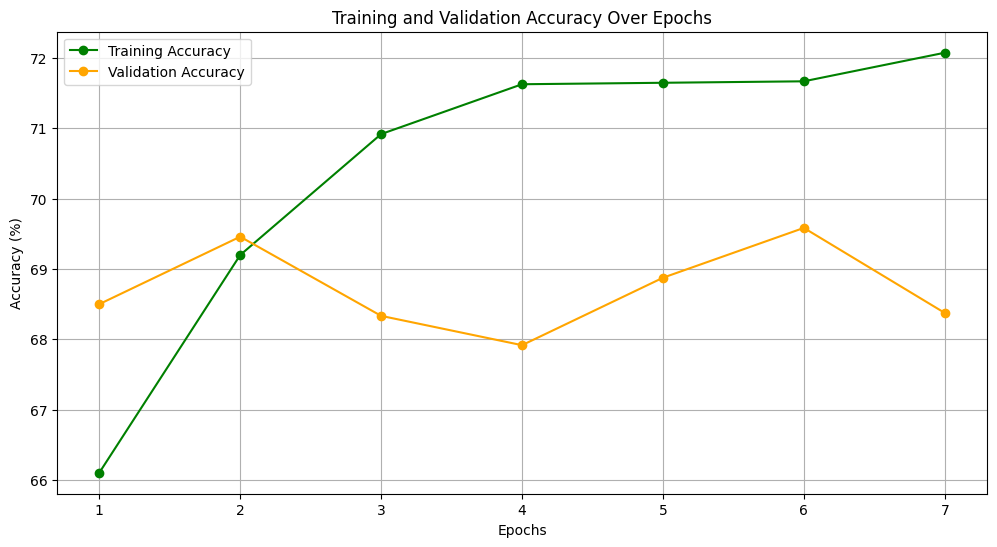

In [57]:
epochs = list(range(1, 8))

train_loss = [
    0.8118341407179832, 0.7475734608372052, 0.7142591155568758,
    0.6992513253291448, 0.698446586082379, 0.7089028457800547,
    0.7095555138091246
]

val_loss = [
    0.7557618467013041, 0.7199077733357747, 0.7882109181086222,
    0.7668063692251841, 0.7578653045495352, 0.7662060678005218,
    0.7671362678209941
]

train_acc = [
    66.10416666666667, 69.19791666666667, 70.91666666666667,
    71.625, 71.64583333333333, 71.66666666666667,
    72.07291666666667
]

val_acc = [
    68.5, 69.45833333333333, 68.33333333333333,
    67.91666666666667, 68.875, 69.58333333333333,
    68.375
]

# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', color='green', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### VGG16 (ADAM + 50% Dropouts + 0.01 Weight Decay)

In [33]:
# loading the pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# freezing all the parameters so we can only train the final layer
for param in model.parameters():
    param.requires_grad = False

# modifying the classifier layer
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 3)

# adding Dropout to the classifier
model.classifier = nn.Sequential(
    model.classifier[0],
    model.classifier[1],
    nn.Dropout(0.5),
    model.classifier[3],
    model.classifier[4],
    nn.Dropout(0.5),
    model.classifier[6]
)

# defining the loss function
criterion = nn.CrossEntropyLoss()

# defining the optimizer with Adam and weight decay for regularization
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001, weight_decay=0.01)

# Cosine Annealing scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0

# training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # training step
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {100*correct/total}%")

    # evaluating on the validation set to check for early stopping
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss}, Validation Accuracy: {100 * correct_val / total_val}%")

    # early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset the counter since validation loss improved
        # Save the best model so far
        torch.save(model.state_dict(), "vgg16_dog_cat_bird_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
            break

    # updating the learning rate using Cosine Annealing Scheduler
    scheduler.step()

# evaluating the model on the validation set after training
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Validation Accuracy: {100 * correct / total}%")

Epoch 1/50, Loss: 0.8965039272109667, Accuracy: 63.635416666666664%
Validation Loss: 0.7461609745025635, Validation Accuracy: 68.45833333333333%
Epoch 2/50, Loss: 0.8622483898202579, Accuracy: 65.94791666666667%
Validation Loss: 0.7463780991236368, Validation Accuracy: 68.04166666666667%
Epoch 3/50, Loss: 0.846620698471864, Accuracy: 67.08333333333333%
Validation Loss: 0.7702659467856089, Validation Accuracy: 67.91666666666667%
Epoch 4/50, Loss: 0.8700095345576604, Accuracy: 66.84375%
Validation Loss: 0.7718560874462128, Validation Accuracy: 68.83333333333333%
Epoch 5/50, Loss: 0.8574518396457036, Accuracy: 67.22916666666667%
Validation Loss: 0.7164564657211304, Validation Accuracy: 70.41666666666667%
Epoch 6/50, Loss: 0.8754408609867096, Accuracy: 67.15625%
Validation Loss: 0.7476525012652079, Validation Accuracy: 68.66666666666667%
Epoch 7/50, Loss: 0.880898657143116, Accuracy: 66.625%
Validation Loss: 0.7395554431279501, Validation Accuracy: 69.16666666666667%
Epoch 8/50, Loss: 0.85

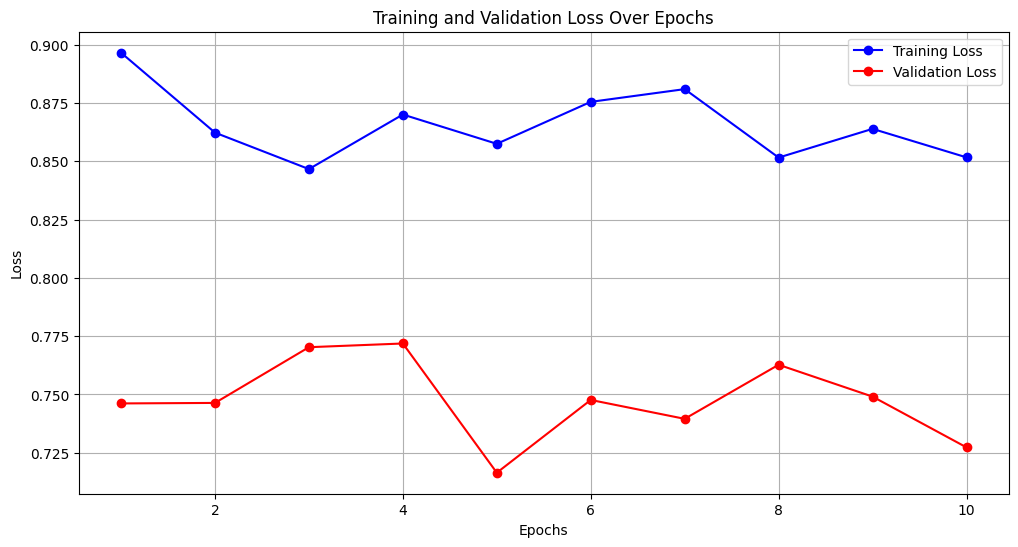

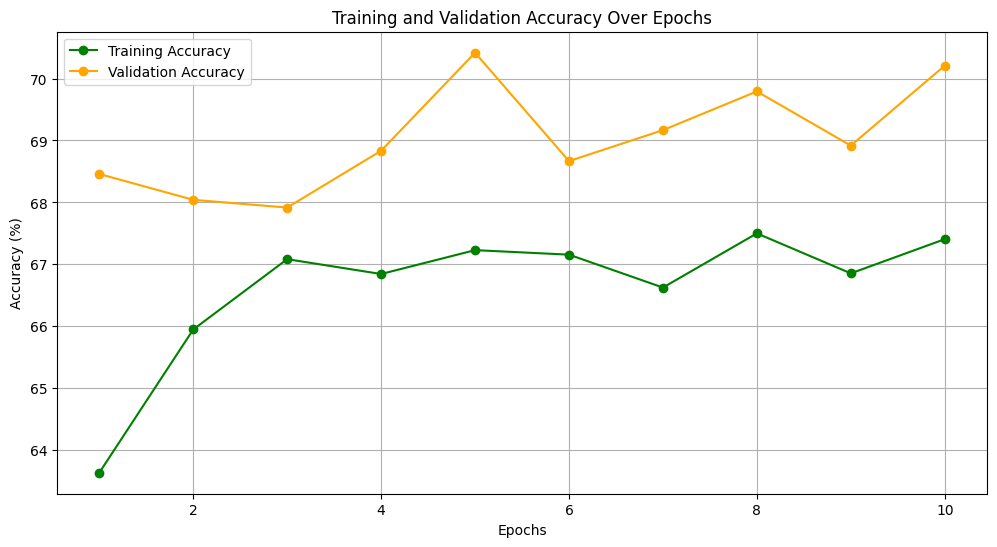

In [58]:
epochs = list(range(1, 11))

train_loss = [
    0.8965039272109667, 0.8622483898202579, 0.846620698471864,
    0.8700095345576604, 0.8574518396457036, 0.8754408609867096,
    0.880898657143116, 0.8515534012516339, 0.8638687961300214, 
    0.851640980442365
]

val_loss = [
    0.7461609745025635, 0.7463780991236368, 0.7702659467856089,
    0.7718560874462128, 0.7164564657211304, 0.7476525012652079,
    0.7395554431279501, 0.7627394231160481, 0.7490827055772146,
    0.7273253893852234
]

train_acc = [
    63.635416666666664, 65.94791666666667, 67.08333333333333,
    66.84375, 67.22916666666667, 67.15625,
    66.625, 67.5, 66.85416666666667,
    67.40625
]

val_acc = [
    68.45833333333333, 68.04166666666667, 67.91666666666667,
    68.83333333333333, 70.41666666666667, 68.66666666666667,
    69.16666666666667, 69.79166666666667, 68.91666666666667,
    70.20833333333333
]

# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', color='green', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### VGG16 (ADAM + 50% Dropouts + 0.1 Weight Decay)

In [37]:
# loading the pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# freezing all the parameters so we can only train the final layer
for param in model.parameters():
    param.requires_grad = False

# modifying the classifier layer
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 3)

# adding Dropout to the classifier
model.classifier = nn.Sequential(
    model.classifier[0],
    model.classifier[1],
    nn.Dropout(0.5),
    model.classifier[3],
    model.classifier[4],
    nn.Dropout(0.5),
    model.classifier[6]
)

# defining the loss function
criterion = nn.CrossEntropyLoss()

# defining the optimizer with Adam and weight decay for regularization
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001, weight_decay=0.1)

# Cosine Annealing scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0

# training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # training step
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {100*correct/total}%")

    # evaluating on the validation set to check for early stopping
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss}, Validation Accuracy: {100 * correct_val / total_val}%")

    # early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset the counter since validation loss improved
        # Save the best model so far
        torch.save(model.state_dict(), "vgg16_dog_cat_bird_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
            break

    # updating the learning rate using Cosine Annealing Scheduler
    scheduler.step()

# evaluating the model on the validation set after training
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Validation Accuracy: {100 * correct / total}%")

Epoch 1/50, Loss: 0.8742601490020752, Accuracy: 64.02083333333333%
Validation Loss: 0.7091842265923818, Validation Accuracy: 69.20833333333333%
Epoch 2/50, Loss: 0.8353154235084852, Accuracy: 66.09375%
Validation Loss: 0.7118167511622111, Validation Accuracy: 69.5%
Epoch 3/50, Loss: 0.8571572332580885, Accuracy: 65.26041666666667%
Validation Loss: 0.7673631791273753, Validation Accuracy: 66.5%
Epoch 4/50, Loss: 0.8185217874248822, Accuracy: 66.92708333333333%
Validation Loss: 0.7506781820456186, Validation Accuracy: 68.08333333333333%
Epoch 5/50, Loss: 0.8351071842511495, Accuracy: 65.77083333333333%
Validation Loss: 0.7232384860515595, Validation Accuracy: 69.16666666666667%
Epoch 6/50, Loss: 0.8286957181493442, Accuracy: 66.59375%
Validation Loss: 0.7693061677614847, Validation Accuracy: 66.41666666666667%
Early stopping triggered. Stopping training at epoch 6.
Final Validation Accuracy: 66.41666666666667%


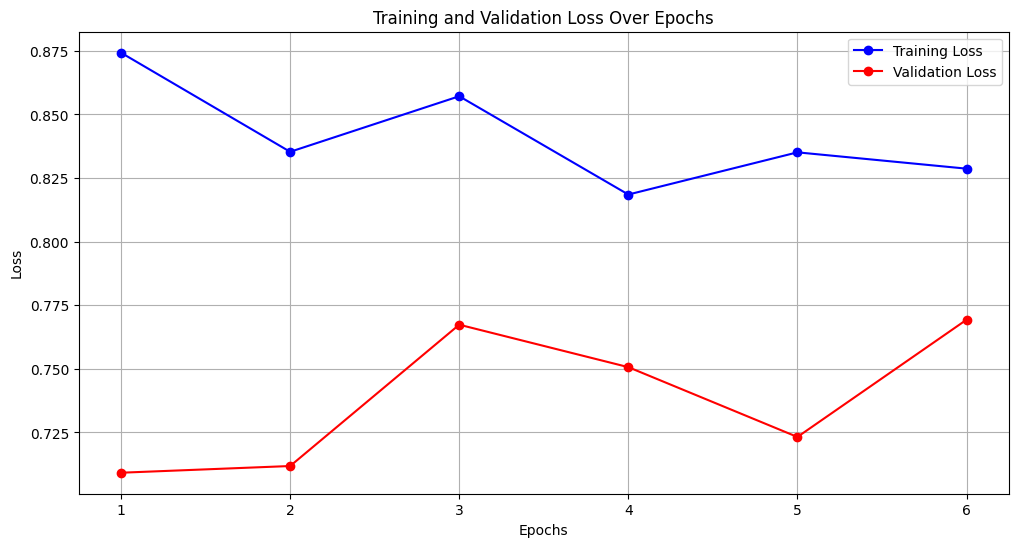

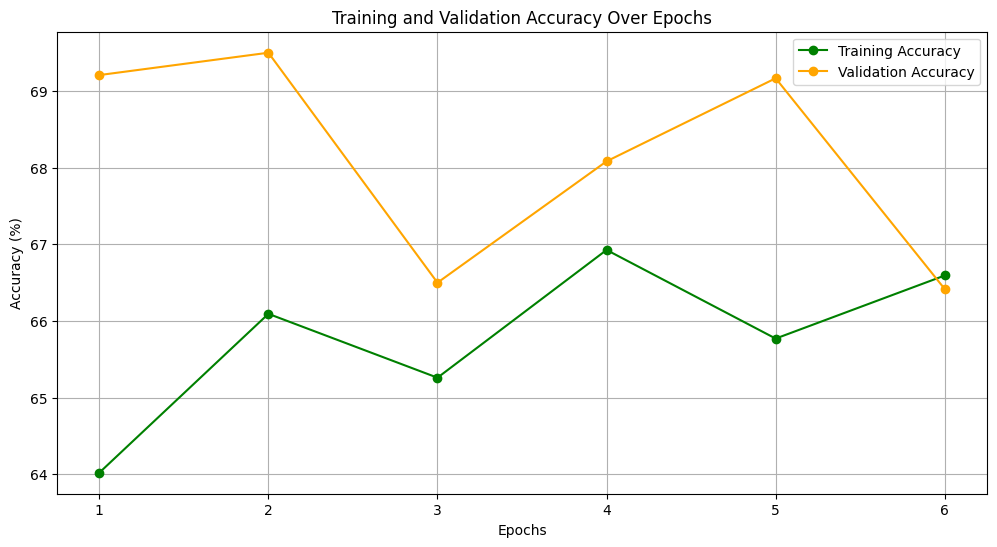

In [59]:
epochs = list(range(1, 7))

train_loss = [
    0.8742601490020752, 0.8353154235084852, 0.8571572332580885,
    0.8185217874248822, 0.8351071842511495, 0.8286957181493442
]

val_loss = [
    0.7091842265923818, 0.7118167511622111, 0.7673631791273753,
    0.7506781820456186, 0.7232384860515595, 0.7693061677614847
]

train_acc = [
    64.02083333333333, 66.09375, 65.26041666666667,
    66.92708333333333, 65.77083333333333, 66.59375
]

val_acc = [
    69.20833333333333, 69.5, 66.5,
    68.08333333333333, 69.16666666666667, 66.41666666666667
]

# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', color='green', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### VGG16 (ADAM + 50% Dropouts + 0.01 Weight Decay + Batch Normalization)

In [32]:
# loading the pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# freezing all the parameters so we can only train the final layer
for param in model.parameters():
    param.requires_grad = False

# modifying the classifier layer
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 3)

# adding Dropout and Batch Normalization to the classifier
model.classifier = nn.Sequential(
    model.classifier[0],
    model.classifier[1],
    nn.BatchNorm1d(4096),
    nn.Dropout(0.5),
    model.classifier[3],
    model.classifier[4],
    nn.BatchNorm1d(4096),
    nn.Dropout(0.5),
    model.classifier[6]
)

# defining the loss function
criterion = nn.CrossEntropyLoss()

# defining the optimizer with Adam and weight decay for regularization
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001, weight_decay=0.01)

# Cosine Annealing scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0

# training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # training step
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {100*correct/total}%")

    # evaluating on the validation set to check for early stopping
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss}, Validation Accuracy: {100 * correct_val / total_val}%")

    # early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset the counter since validation loss improved
        # Save the best model so far
        torch.save(model.state_dict(), "vgg16_dog_cat_bird_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
            break

    # updating the learning rate using Cosine Annealing Scheduler
    scheduler.step()

# evaluating the model on the validation set after training
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Validation Accuracy: {100 * correct / total}%")

Epoch 1/50, Loss: 0.9077514917651812, Accuracy: 63.322916666666664%
Validation Loss: 0.727883001168569, Validation Accuracy: 68.58333333333333%
Epoch 2/50, Loss: 0.793108803431193, Accuracy: 66.76041666666667%
Validation Loss: 0.684466149409612, Validation Accuracy: 70.0%
Epoch 3/50, Loss: 0.7339171871542931, Accuracy: 68.48958333333333%
Validation Loss: 0.693238308429718, Validation Accuracy: 69.70833333333333%
Epoch 4/50, Loss: 0.7142804153760274, Accuracy: 69.125%
Validation Loss: 0.6915374573071797, Validation Accuracy: 69.33333333333333%
Epoch 5/50, Loss: 0.7045457752545675, Accuracy: 69.77083333333333%
Validation Loss: 0.6981173944473267, Validation Accuracy: 69.54166666666667%
Epoch 6/50, Loss: 0.7005659115314483, Accuracy: 70.34375%
Validation Loss: 0.7013385407129924, Validation Accuracy: 69.625%
Epoch 7/50, Loss: 0.7058765784899393, Accuracy: 69.5625%
Validation Loss: 0.6957192528247833, Validation Accuracy: 70.625%
Early stopping triggered. Stopping training at epoch 7.
Fina

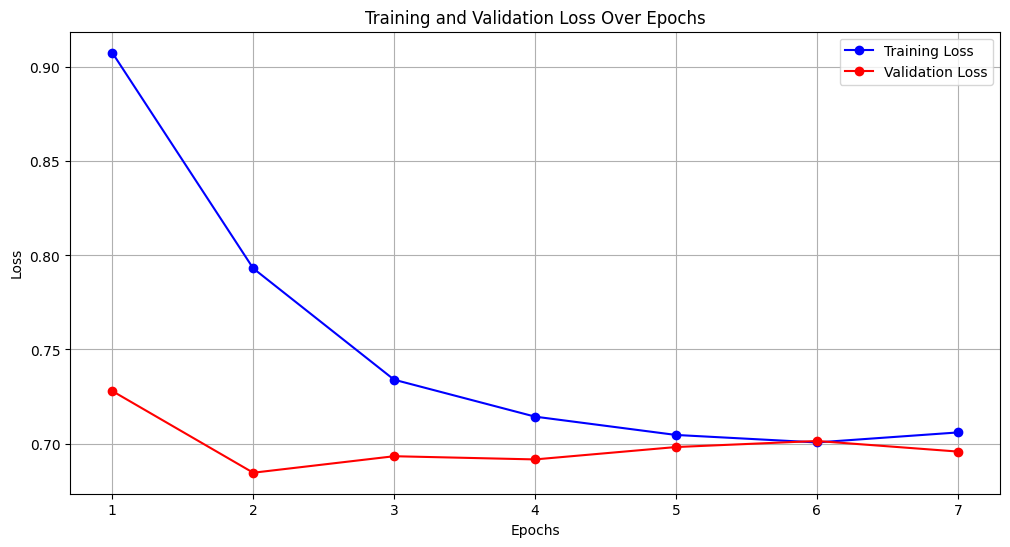

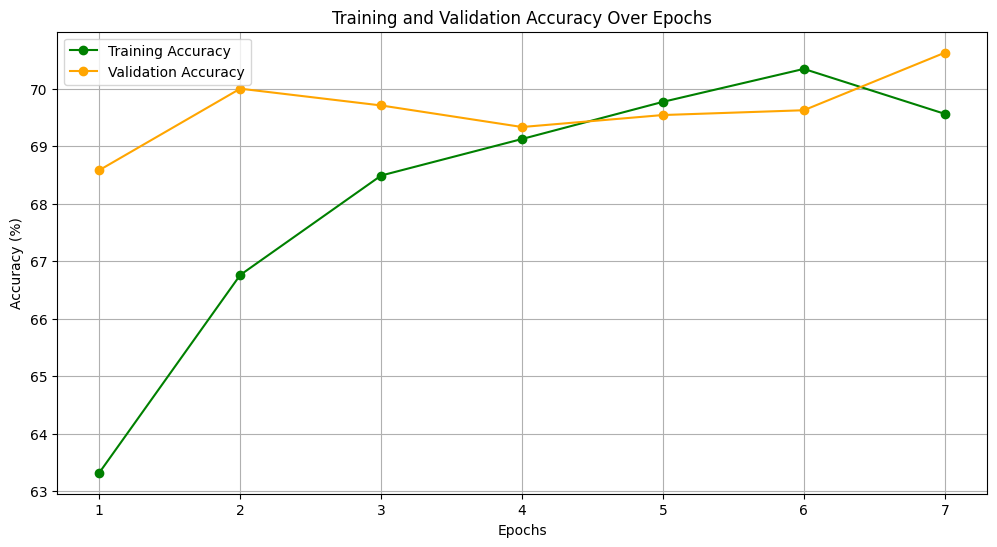

In [60]:
epochs = list(range(1, 8))

train_loss = [
    0.9077514917651812, 0.793108803431193, 0.7339171871542931,
    0.7142804153760274, 0.7045457752545675, 0.7005659115314483,
    0.7058765784899393
]

val_loss = [
    0.727883001168569, 0.684466149409612, 0.693238308429718,
    0.6915374573071797, 0.6981173944473267, 0.7013385407129924,
    0.6957192528247833
]

train_acc = [
    63.322916666666664, 66.76041666666667, 68.48958333333333,
    69.125, 69.77083333333333, 70.34375, 69.5625
]

val_acc = [
    68.58333333333333, 70.0, 69.70833333333333,
    69.33333333333333, 69.54166666666667, 69.625,
    70.625
]

# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', color='green', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### VGG16 (ADAM + 50% Dropouts + 0.001 Weight Decay + Batch Normalization)

In [50]:
# loading the pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# freezing all the parameters so we can only train the final layer
for param in model.parameters():
    param.requires_grad = False

# modifying the classifier layer
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 3)

# adding Dropout and Batch Normalization to the classifier
model.classifier = nn.Sequential(
    model.classifier[0],
    model.classifier[1],
    nn.BatchNorm1d(4096),
    nn.Dropout(0.5),
    model.classifier[3],
    model.classifier[4],
    nn.BatchNorm1d(4096),
    nn.Dropout(0.5),
    model.classifier[6]
)

# defining the loss function
criterion = nn.CrossEntropyLoss()

# defining the optimizer with Adam and weight decay for regularization
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001, weight_decay=0.001)

# Cosine Annealing scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0

# training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # training step
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {100*correct/total}%")

    # evaluating on the validation set to check for early stopping
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss}, Validation Accuracy: {100 * correct_val / total_val}%")

    # early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset the counter since validation loss improved
        # Save the best model so far
        torch.save(model.state_dict(), "vgg16_dog_cat_bird_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
            break

    # updating the learning rate using Cosine Annealing Scheduler
    scheduler.step()

# evaluating the model on the validation set after training
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Validation Accuracy: {100 * correct / total}%")

Epoch 1/50, Loss: 0.9369393356641134, Accuracy: 62.947916666666664%
Validation Loss: 0.773867023785909, Validation Accuracy: 66.91666666666667%
Epoch 2/50, Loss: 0.8774636533856391, Accuracy: 64.82291666666667%
Validation Loss: 0.7241321659088135, Validation Accuracy: 69.54166666666667%
Epoch 3/50, Loss: 0.8532523234685262, Accuracy: 65.6875%
Validation Loss: 0.7008857830365499, Validation Accuracy: 69.66666666666667%
Epoch 4/50, Loss: 0.8028943051894506, Accuracy: 66.5625%
Validation Loss: 0.6862401103973389, Validation Accuracy: 70.70833333333333%
Epoch 5/50, Loss: 0.772676840921243, Accuracy: 67.27083333333333%
Validation Loss: 0.691004231373469, Validation Accuracy: 70.375%
Epoch 6/50, Loss: 0.7474618099133173, Accuracy: 68.58333333333333%
Validation Loss: 0.664064362446467, Validation Accuracy: 71.125%
Epoch 7/50, Loss: 0.7297434308131536, Accuracy: 68.80208333333333%
Validation Loss: 0.670558709303538, Validation Accuracy: 71.08333333333333%
Epoch 8/50, Loss: 0.7102954615155855, 

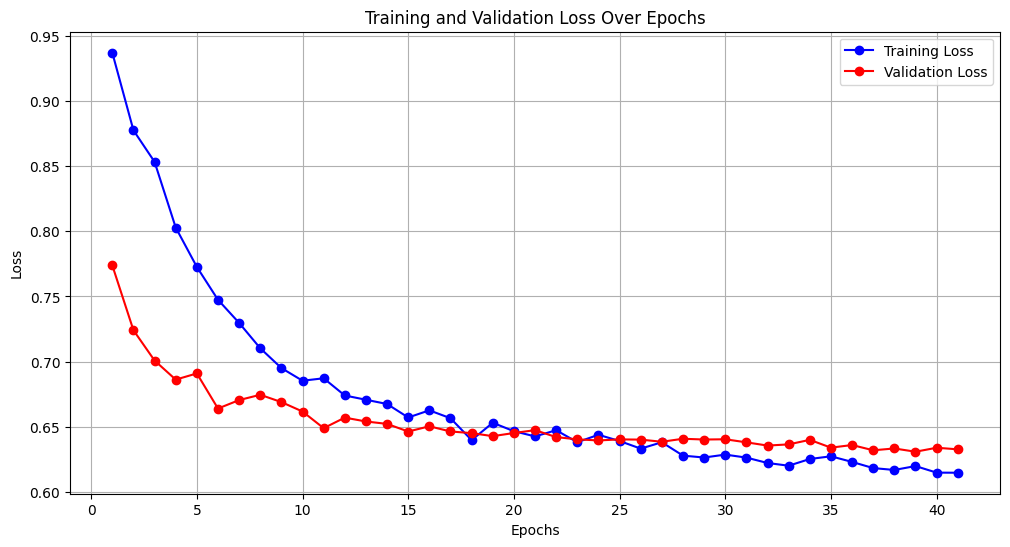

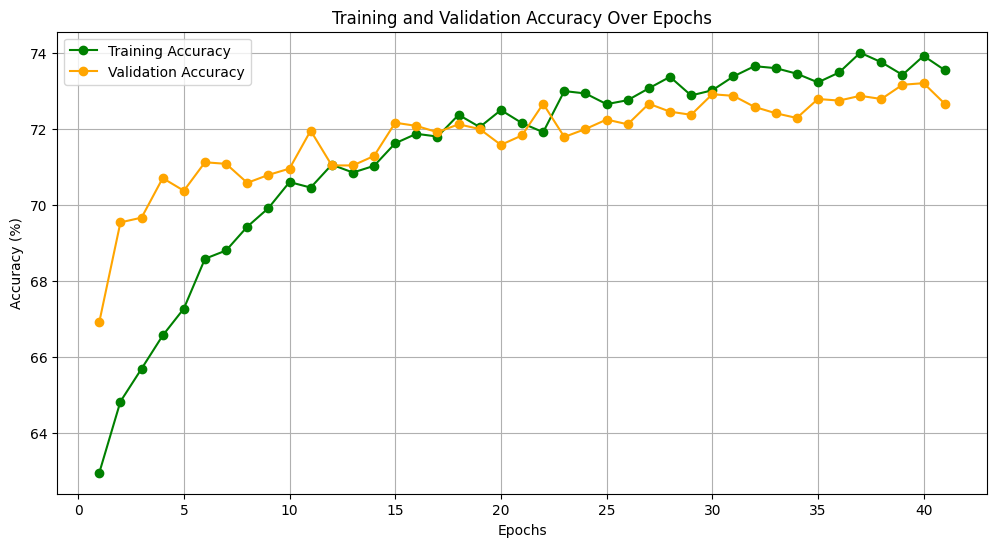

In [62]:
epochs = list(range(1, len(val_loss) + 1))

train_loss = [
    0.9369393356641134, 0.8774636533856391, 0.8532523234685262,
    0.8028943051894506, 0.772676840921243, 0.7474618099133173,
    0.7297434308131536, 0.7102954615155855, 0.6951095274090767,
    0.6854022888342539, 0.6872693366805712, 0.6740738546848297,
    0.6708126907547315, 0.6675521447261175, 0.6572039607167244,
    0.6626899845401446, 0.6566377073526383, 0.6398531000812848,
    0.6531481330593427, 0.6466995509465535, 0.6426961739857991,
    0.6474347827831904, 0.6382370695471764, 0.6439460694789887,
    0.6391623110572497, 0.633321583767732, 0.6382083127895991,
    0.6279503637552262, 0.6265095375974973, 0.6287335276603698,
    0.6264483654499053, 0.6223068601886431, 0.6202194459239642,
    0.6253629306952159, 0.6274469151099523, 0.6231241689125697,
    0.6184018061558405, 0.6169611676534017, 0.6199582493305207,
    0.6149152766664823, 0.6148465414841969
]

val_loss = [
    0.773867023785909, 0.7241321659088135, 0.7008857830365499,
    0.6862401103973389, 0.691004231373469, 0.664064362446467,
    0.670558709303538, 0.6746215911706289, 0.6690232801437378,
    0.6617799599965414, 0.6490174957116445, 0.6571064150333404,
    0.6541431021690368, 0.6522923179467519, 0.6464371387163798,
    0.6504545684655507, 0.6464862819512686, 0.6452164657910665,
    0.6428945382436116, 0.6452988064289094, 0.6474965862433115,
    0.6421627815564473, 0.640436414082845, 0.6396006158987682,
    0.6404039569695791, 0.6402419877052307, 0.6385916554927826,
    0.6408871249357859, 0.6403082732359568, 0.640497434536616,
    0.6381469058990479, 0.635668105284373, 0.6365810386339823,
    0.640053867896398, 0.634077539841334, 0.6360846368471781,
    0.6320525419712066, 0.6334482296307882, 0.6309459276994069,
    0.6340034111340841, 0.6327882651487986
]

train_acc = [
    62.947916666666664, 64.82291666666667, 65.6875, 66.5625, 67.27083333333333,
    68.58333333333333, 68.80208333333333, 69.42708333333333, 69.91666666666667,
    70.60416666666667, 70.45833333333333, 71.0625, 70.85416666666667, 71.03125,
    71.625, 71.875, 71.80208333333333, 72.375, 72.05208333333333, 72.5, 72.15625,
    71.91666666666667, 73.0, 72.9375, 72.65625, 72.76041666666667, 73.07291666666667,
    73.375, 72.88541666666667, 73.02083333333333, 73.38541666666667, 73.65625,
    73.60416666666667, 73.45833333333333, 73.22916666666667, 73.48958333333333,
    74.01041666666667, 73.76041666666667, 73.42708333333333, 73.92708333333333,
    73.55208333333333, 74.03125
]

val_acc = [
    66.91666666666667, 69.54166666666667, 69.66666666666667, 70.70833333333333,
    70.375, 71.125, 71.08333333333333, 70.58333333333333, 70.79166666666667,
    70.95833333333333, 71.95833333333333, 71.04166666666667, 71.04166666666667,
    71.29166666666667, 72.16666666666667, 72.08333333333333, 71.91666666666667,
    72.125, 72.0, 71.58333333333333, 71.83333333333333, 72.66666666666667,
    71.79166666666667, 72.0, 72.25, 72.125, 72.66666666666667, 72.45833333333333,
    72.375, 72.91666666666667, 72.875, 72.58333333333333, 72.41666666666667,
    72.29166666666667, 72.79166666666667, 72.75, 72.875, 72.79166666666667,
    73.16666666666667, 73.20833333333333, 72.66666666666667, 73.08333333333333,
    73.375
]


# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss[:len(epochs)], label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc[:len(epochs)], label='Training Accuracy', color='green', marker='o')
plt.plot(epochs, val_acc[:len(epochs)], label='Validation Accuracy', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### VGG16 (ADAM + 50% Dropouts + 0.1 Weight Decay + Batch Normalization)

In [38]:
# loading the pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# freezing all the parameters so we can only train the final layer
for param in model.parameters():
    param.requires_grad = False

# modifying the classifier layer
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 3)

# adding Dropout and Batch Normalization to the classifier
model.classifier = nn.Sequential(
    model.classifier[0],
    model.classifier[1],
    nn.BatchNorm1d(4096),
    nn.Dropout(0.5),
    model.classifier[3],
    model.classifier[4],
    nn.BatchNorm1d(4096),
    nn.Dropout(0.5),
    model.classifier[6]
)

# defining the loss function
criterion = nn.CrossEntropyLoss()

# defining the optimizer with Adam and weight decay for regularization
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001, weight_decay=0.1)

# Cosine Annealing scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0

# training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # training step
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {100*correct/total}%")

    # evaluating on the validation set to check for early stopping
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss}, Validation Accuracy: {100 * correct_val / total_val}%")

    # early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset the counter since validation loss improved
        # Save the best model so far
        torch.save(model.state_dict(), "vgg16_dog_cat_bird_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
            break

    # updating the learning rate using Cosine Annealing Scheduler
    scheduler.step()

# evaluating the model on the validation set after training
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Validation Accuracy: {100 * correct / total}%")

Epoch 1/50, Loss: 0.8861252640684446, Accuracy: 63.375%
Validation Loss: 0.7286627908547719, Validation Accuracy: 68.33333333333333%
Epoch 2/50, Loss: 0.7706786796450615, Accuracy: 67.04166666666667%
Validation Loss: 0.7076996835072835, Validation Accuracy: 68.83333333333333%
Epoch 3/50, Loss: 0.7262214703361193, Accuracy: 67.72916666666667%
Validation Loss: 0.7133240246772766, Validation Accuracy: 68.79166666666667%
Epoch 4/50, Loss: 0.7237742631634076, Accuracy: 68.79166666666667%
Validation Loss: 0.7336799085140229, Validation Accuracy: 68.16666666666667%
Epoch 5/50, Loss: 0.7539380862315496, Accuracy: 68.55208333333333%
Validation Loss: 0.7804265308380127, Validation Accuracy: 67.5%
Epoch 6/50, Loss: 0.8041174083948135, Accuracy: 67.54166666666667%
Validation Loss: 0.841890364487966, Validation Accuracy: 66.54166666666667%
Epoch 7/50, Loss: 0.8479111252228418, Accuracy: 66.77083333333333%
Validation Loss: 0.8563337508837382, Validation Accuracy: 66.5%
Early stopping triggered. Stop

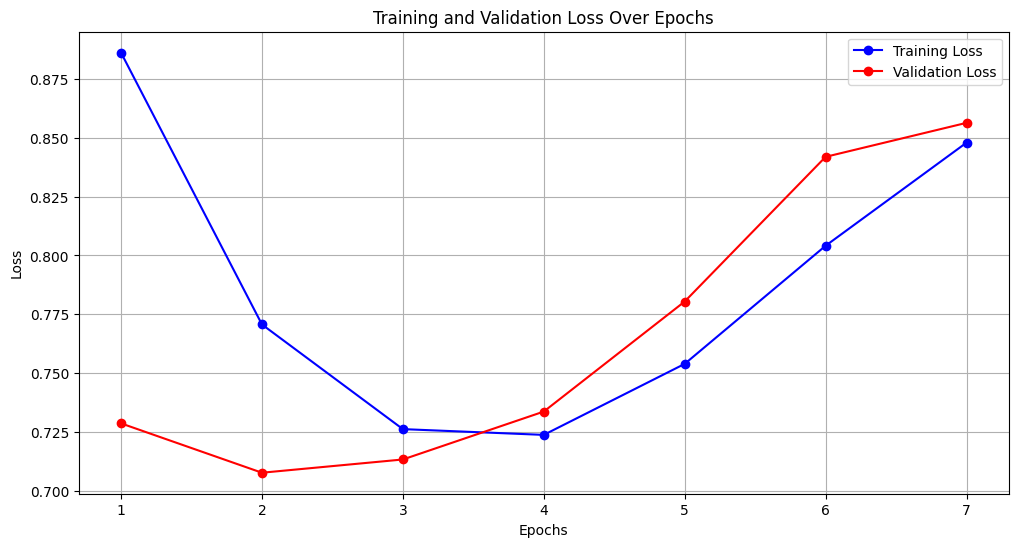

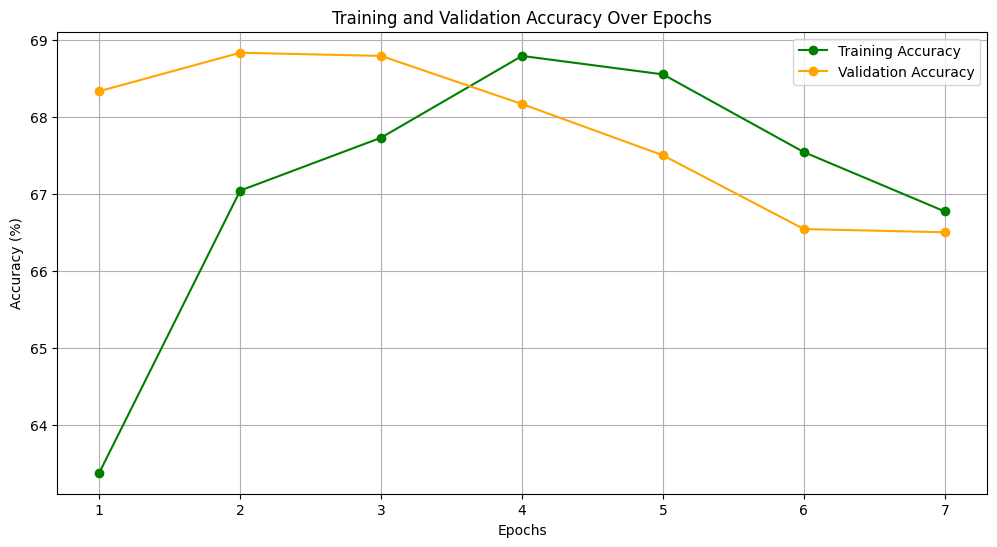

In [63]:
epochs = list(range(1, 8))

train_loss = [
    0.8861252640684446, 0.7706786796450615, 0.7262214703361193, 
    0.7237742631634076, 0.7539380862315496, 0.8041174083948135, 
    0.8479111252228418
]

val_loss = [
    0.7286627908547719, 0.7076996835072835, 0.7133240246772766, 
    0.7336799085140229, 0.7804265308380127, 0.841890364487966, 
    0.8563337508837382
]

train_acc = [
    63.375, 67.04166666666667, 67.72916666666667, 68.79166666666667, 
    68.55208333333333, 67.54166666666667, 66.77083333333333
]

val_acc = [
    68.33333333333333, 68.83333333333333, 68.79166666666667, 
    68.16666666666667, 67.5, 66.54166666666667, 66.5
]

# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', color='green', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### VGG16 (ADAM + 30% Dropouts + 0.01 Weight Decay + Batch Normalization)

In [39]:
# loading the pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# freezing all the parameters so we can only train the final layer
for param in model.parameters():
    param.requires_grad = False

# modifying the classifier layer
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 3)

# adding Dropout and Batch Normalization to the classifier
model.classifier = nn.Sequential(
    model.classifier[0],
    model.classifier[1],
    nn.BatchNorm1d(4096),
    nn.Dropout(0.3),
    model.classifier[3],
    model.classifier[4],
    nn.BatchNorm1d(4096),
    nn.Dropout(0.3),
    model.classifier[6]
)

# defining the loss function
criterion = nn.CrossEntropyLoss()

# defining the optimizer with Adam and weight decay for regularization
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001, weight_decay=0.01)

# Cosine Annealing scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0

# training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # training step
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {100*correct/total}%")

    # evaluating on the validation set to check for early stopping
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss}, Validation Accuracy: {100 * correct_val / total_val}%")

    # early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset the counter since validation loss improved
        # Save the best model so far
        torch.save(model.state_dict(), "vgg16_dog_cat_bird_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
            break

    # updating the learning rate using Cosine Annealing Scheduler
    scheduler.step()

# evaluating the model on the validation set after training
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Validation Accuracy: {100 * correct / total}%")

Epoch 1/50, Loss: 0.8458807749549547, Accuracy: 65.01041666666667%
Validation Loss: 0.7447611355781555, Validation Accuracy: 67.29166666666667%
Epoch 2/50, Loss: 0.744935819307963, Accuracy: 68.6875%
Validation Loss: 0.7171934648354849, Validation Accuracy: 68.66666666666667%
Epoch 3/50, Loss: 0.6922373073299726, Accuracy: 70.07291666666667%
Validation Loss: 0.6755083250999451, Validation Accuracy: 70.45833333333333%
Epoch 4/50, Loss: 0.6749268089731534, Accuracy: 71.25%
Validation Loss: 0.6832910867532095, Validation Accuracy: 69.875%
Epoch 5/50, Loss: 0.6780019174019496, Accuracy: 71.09375%
Validation Loss: 0.6983971579869588, Validation Accuracy: 69.5%
Epoch 6/50, Loss: 0.6806857976317405, Accuracy: 71.5625%
Validation Loss: 0.6878183388710022, Validation Accuracy: 70.70833333333333%
Epoch 7/50, Loss: 0.6831884523232777, Accuracy: 70.78125%
Validation Loss: 0.6942698013782501, Validation Accuracy: 70.0%
Epoch 8/50, Loss: 0.6769188975294431, Accuracy: 71.22916666666667%
Validation Lo

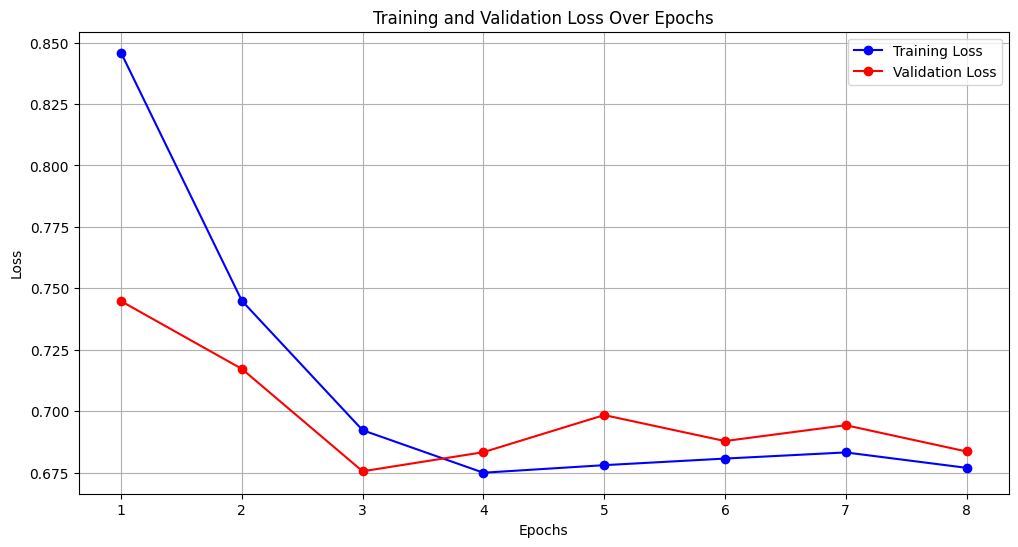

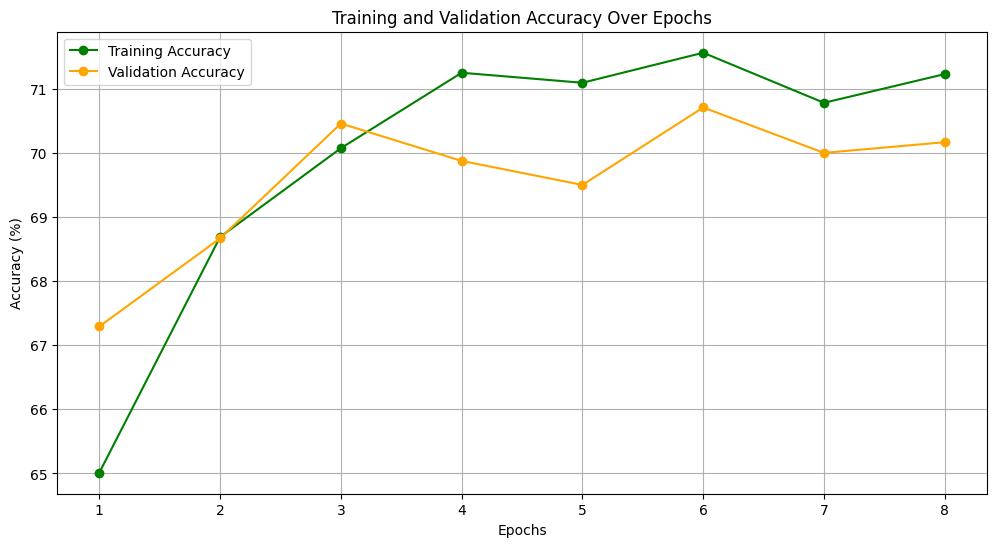

In [64]:
epochs = list(range(1, 9))

train_loss = [
    0.8458807749549547, 0.744935819307963, 0.6922373073299726, 
    0.6749268089731534, 0.6780019174019496, 0.6806857976317405, 
    0.6831884523232777, 0.6769188975294431
]

val_loss = [
    0.7447611355781555, 0.7171934648354849, 0.6755083250999451, 
    0.6832910867532095, 0.6983971579869588, 0.6878183388710022, 
    0.6942698013782501, 0.6835732301076253
]

train_acc = [
    65.01041666666667, 68.6875, 70.07291666666667, 71.25, 
    71.09375, 71.5625, 70.78125, 71.22916666666667
]

val_acc = [
    67.29166666666667, 68.66666666666667, 70.45833333333333, 
    69.875, 69.5, 70.70833333333333, 70.0, 70.16666666666667
]

# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', color='green', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### VGG16 (ADAM + 30% Dropouts + 0.1 Weight Decay + Batch Normalization)

In [40]:
# loading the pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# freezing all the parameters so we can only train the final layer
for param in model.parameters():
    param.requires_grad = False

# modifying the classifier layer
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 3)

# adding Dropout and Batch Normalization to the classifier
model.classifier = nn.Sequential(
    model.classifier[0],
    model.classifier[1],
    nn.BatchNorm1d(4096),
    nn.Dropout(0.3),
    model.classifier[3],
    model.classifier[4],
    nn.BatchNorm1d(4096),
    nn.Dropout(0.3),
    model.classifier[6]
)

# defining the loss function
criterion = nn.CrossEntropyLoss()

# defining the optimizer with Adam and weight decay for regularization
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001, weight_decay=0.1)

# Cosine Annealing scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0

# training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # training step
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {100*correct/total}%")

    # evaluating on the validation set to check for early stopping
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss}, Validation Accuracy: {100 * correct_val / total_val}%")

    # early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset the counter since validation loss improved
        # Save the best model so far
        torch.save(model.state_dict(), "vgg16_dog_cat_bird_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
            break

    # updating the learning rate using Cosine Annealing Scheduler
    scheduler.step()

# evaluating the model on the validation set after training
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Validation Accuracy: {100 * correct / total}%")

Epoch 1/50, Loss: 0.8403232102592786, Accuracy: 64.48958333333333%
Validation Loss: 0.7486738427480062, Validation Accuracy: 67.66666666666667%
Epoch 2/50, Loss: 0.7291678789258004, Accuracy: 68.27083333333333%
Validation Loss: 0.7067314561208089, Validation Accuracy: 69.58333333333333%
Epoch 3/50, Loss: 0.7011247829596201, Accuracy: 70.15625%
Validation Loss: 0.7066357517242432, Validation Accuracy: 69.25%
Epoch 4/50, Loss: 0.7071828282872836, Accuracy: 70.05208333333333%
Validation Loss: 0.723138827085495, Validation Accuracy: 69.08333333333333%
Epoch 5/50, Loss: 0.7409039334456126, Accuracy: 69.09375%
Validation Loss: 0.7805362725257874, Validation Accuracy: 66.95833333333333%
Epoch 6/50, Loss: 0.8003723325332006, Accuracy: 67.39583333333333%
Validation Loss: 0.8359264469146729, Validation Accuracy: 66.375%
Epoch 7/50, Loss: 0.8409838366508484, Accuracy: 66.97916666666667%
Validation Loss: 0.8604089204470317, Validation Accuracy: 66.16666666666667%
Epoch 8/50, Loss: 0.82396504640579

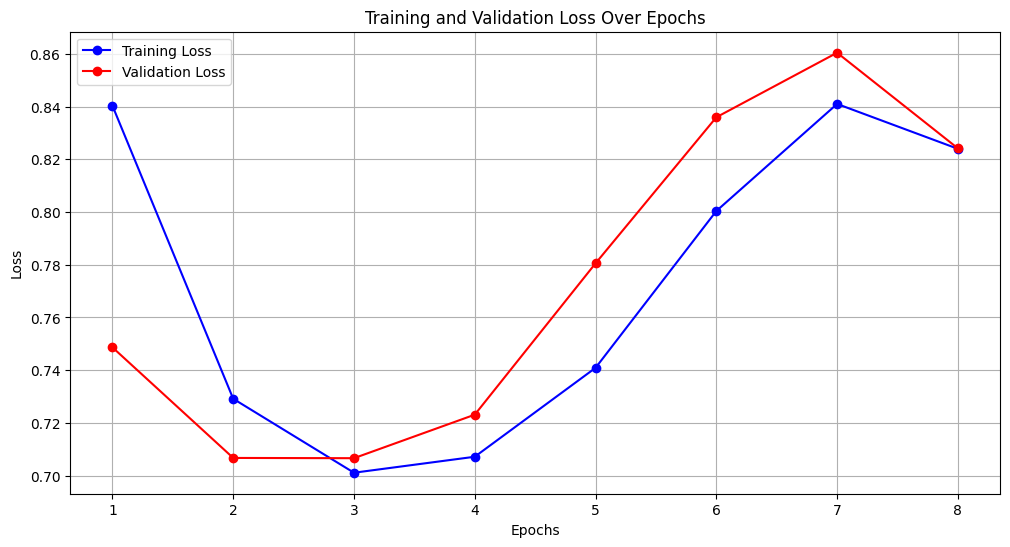

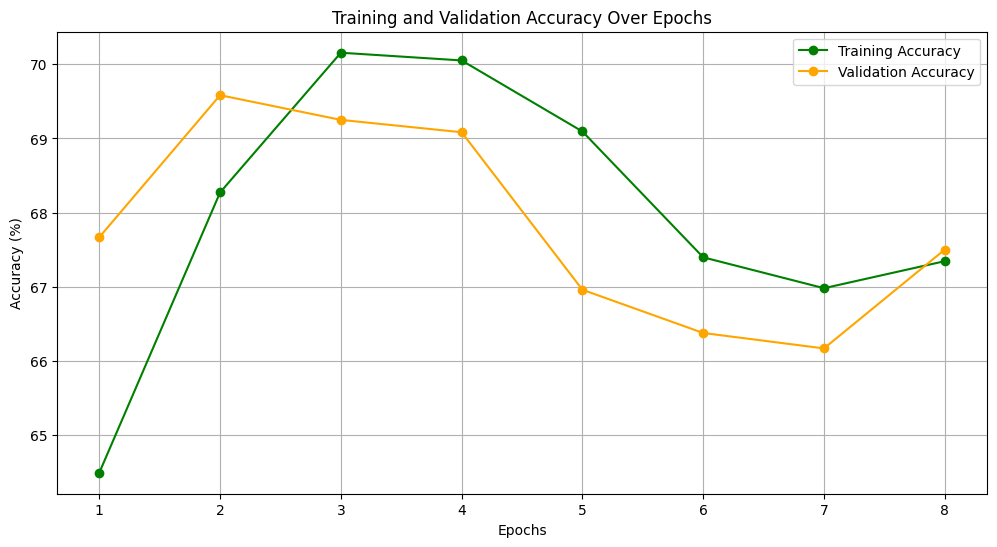

In [65]:
epochs = list(range(1, 9))

train_loss = [
    0.8403232102592786, 0.7291678789258004, 0.7011247829596201, 
    0.7071828282872836, 0.7409039334456126, 0.8003723325332006, 
    0.8409838366508484, 0.8239650464057923
]

val_loss = [
    0.7486738427480062, 0.7067314561208089, 0.7066357517242432, 
    0.723138827085495, 0.7805362725257874, 0.8359264469146729, 
    0.8604089204470317, 0.82414826075236
]

train_acc = [
    64.48958333333333, 68.27083333333333, 70.15625, 70.05208333333333, 
    69.09375, 67.39583333333333, 66.97916666666667, 67.34375
]

val_acc = [
    67.66666666666667, 69.58333333333333, 69.25, 69.08333333333333, 
    66.95833333333333, 66.375, 66.16666666666667, 67.5
]

# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', color='green', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### VGG16 (ADAM + 30\% Dropouts + 0.1 Weight Decay + 0.1 Learning Rate + Batch Normalization)

In [41]:
# loading the pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# freezing all the parameters so we can only train the final layer
for param in model.parameters():
    param.requires_grad = False

# modifying the classifier layer
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 3)

# adding Dropout and Batch Normalization to the classifier
model.classifier = nn.Sequential(
    model.classifier[0],
    model.classifier[1],
    nn.BatchNorm1d(4096),
    nn.Dropout(0.3),
    model.classifier[3],
    model.classifier[4],
    nn.BatchNorm1d(4096),
    nn.Dropout(0.3),
    model.classifier[6]
)

# defining the loss function
criterion = nn.CrossEntropyLoss()

# defining the optimizer with Adam and weight decay for regularization
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.1, weight_decay=0.1)

# Cosine Annealing scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0

# training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # training step
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {100*correct/total}%")

    # evaluating on the validation set to check for early stopping
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss}, Validation Accuracy: {100 * correct_val / total_val}%")

    # early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset the counter since validation loss improved
        # Save the best model so far
        torch.save(model.state_dict(), "vgg16_dog_cat_bird_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
            break

    # updating the learning rate using Cosine Annealing Scheduler
    scheduler.step()

# evaluating the model on the validation set after training
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Validation Accuracy: {100 * correct / total}%")

Epoch 1/50, Loss: 2.255229557553927, Accuracy: 52.53125%
Validation Loss: 0.9791546607017517, Validation Accuracy: 50.583333333333336%
Epoch 2/50, Loss: 0.9697176931301753, Accuracy: 52.270833333333336%
Validation Loss: 1.0166605011622112, Validation Accuracy: 51.0%
Epoch 3/50, Loss: 1.005503246585528, Accuracy: 48.604166666666664%
Validation Loss: 1.1165699068705242, Validation Accuracy: 40.458333333333336%
Epoch 4/50, Loss: 1.374054669936498, Accuracy: 44.479166666666664%
Validation Loss: 1.1643491101264953, Validation Accuracy: 46.083333333333336%
Epoch 5/50, Loss: 1.3662479507923126, Accuracy: 44.145833333333336%
Validation Loss: 3.3053399594624837, Validation Accuracy: 33.333333333333336%
Epoch 6/50, Loss: 2.0498516740401587, Accuracy: 44.354166666666664%
Validation Loss: 0.957149932384491, Validation Accuracy: 55.208333333333336%
Epoch 7/50, Loss: 1.3713449474175772, Accuracy: 47.395833333333336%
Validation Loss: 1.1268420314788818, Validation Accuracy: 44.208333333333336%
Epoch 

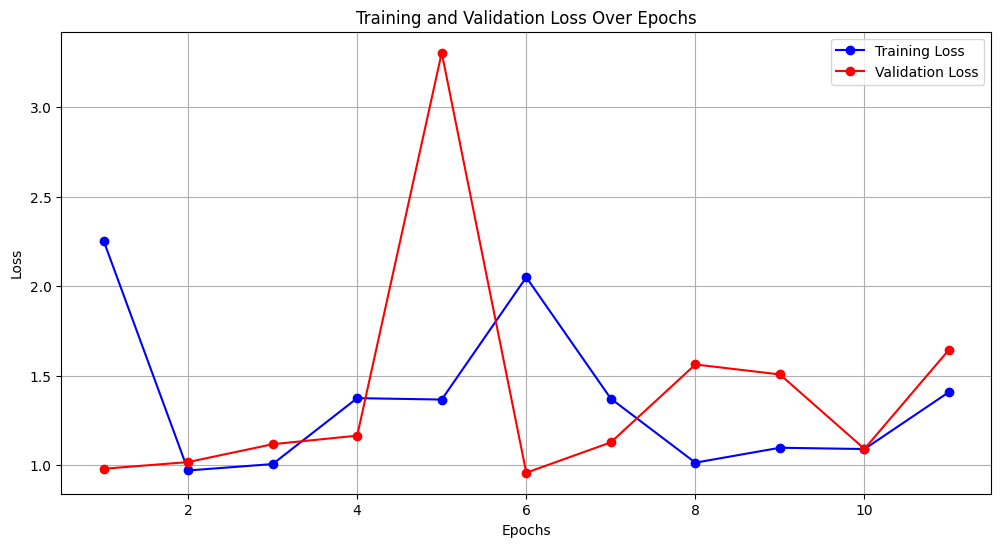

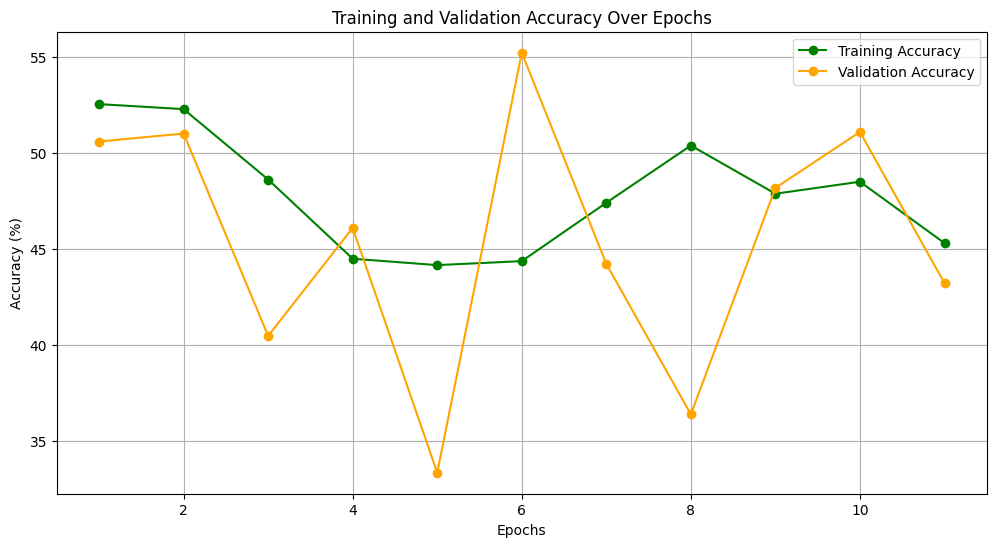

In [66]:
epochs = list(range(1, 12))

train_loss = [
    2.255229557553927, 0.9697176931301753, 1.005503246585528, 
    1.374054669936498, 1.3662479507923126, 2.0498516740401587, 
    1.3713449474175772, 1.013402193983396, 1.0967684636513393, 
    1.0895456393559775, 1.4082201983531315
]

val_loss = [
    0.9791546607017517, 1.0166605011622112, 1.1165699068705242, 
    1.1643491101264953, 3.3053399594624837, 0.957149932384491, 
    1.1268420314788818, 1.56228853225708, 1.506605851650238, 
    1.090348207950592, 1.6449517790476482
]

train_acc = [
    52.53125, 52.270833333333336, 48.604166666666664, 44.479166666666664, 
    44.145833333333336, 44.354166666666664, 47.395833333333336, 50.375, 
    47.864583333333336, 48.489583333333336, 45.291666666666664
]

val_acc = [
    50.583333333333336, 51.0, 40.458333333333336, 46.083333333333336, 
    33.333333333333336, 55.208333333333336, 44.208333333333336, 36.375, 
    48.166666666666664, 51.083333333333336, 43.208333333333336
]

# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', color='green', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### VGG16 (ADAM + 30\% Dropouts + 0.001 Weight Decay + 0.01 Learning Rate + Batch Normalization)

In [43]:
# loading the pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# freezing all the parameters so we can only train the final layer
for param in model.parameters():
    param.requires_grad = False

# modifying the classifier layer
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 3)

# adding Dropout and Batch Normalization to the classifier
model.classifier = nn.Sequential(
    model.classifier[0],
    model.classifier[1],
    nn.BatchNorm1d(4096),
    nn.Dropout(0.3),
    model.classifier[3],
    model.classifier[4],
    nn.BatchNorm1d(4096),
    nn.Dropout(0.3),
    model.classifier[6]
)

# defining the loss function
criterion = nn.CrossEntropyLoss()

# defining the optimizer with Adam and weight decay for regularization
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.01, weight_decay=0.001)

# Cosine Annealing scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0

# training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # training step
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {100*correct/total}%")

    # evaluating on the validation set to check for early stopping
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss}, Validation Accuracy: {100 * correct_val / total_val}%")

    # early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset the counter since validation loss improved
        # Save the best model so far
        torch.save(model.state_dict(), "vgg16_dog_cat_bird_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
            break

    # updating the learning rate using Cosine Annealing Scheduler
    scheduler.step()

# evaluating the model on the validation set after training
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Validation Accuracy: {100 * correct / total}%")

Epoch 1/50, Loss: 3.085242592891057, Accuracy: 59.75%
Validation Loss: 1.7182398732503255, Validation Accuracy: 66.33333333333333%
Epoch 2/50, Loss: 1.7717639688650768, Accuracy: 63.052083333333336%
Validation Loss: 1.3065967321395875, Validation Accuracy: 63.958333333333336%
Epoch 3/50, Loss: 1.1244124115506808, Accuracy: 64.78125%
Validation Loss: 0.7992962241172791, Validation Accuracy: 68.58333333333333%
Epoch 4/50, Loss: 0.818381362259388, Accuracy: 67.19791666666667%
Validation Loss: 0.7327058899402619, Validation Accuracy: 68.375%
Epoch 5/50, Loss: 0.7503866604963938, Accuracy: 67.92708333333333%
Validation Loss: 0.7145514996846517, Validation Accuracy: 68.25%
Epoch 6/50, Loss: 0.7238479507962863, Accuracy: 69.13541666666667%
Validation Loss: 0.7048227039972941, Validation Accuracy: 69.125%
Epoch 7/50, Loss: 0.7175779055555661, Accuracy: 68.75%
Validation Loss: 0.7157631973425548, Validation Accuracy: 69.08333333333333%
Epoch 8/50, Loss: 0.7185831437508265, Accuracy: 68.73958333

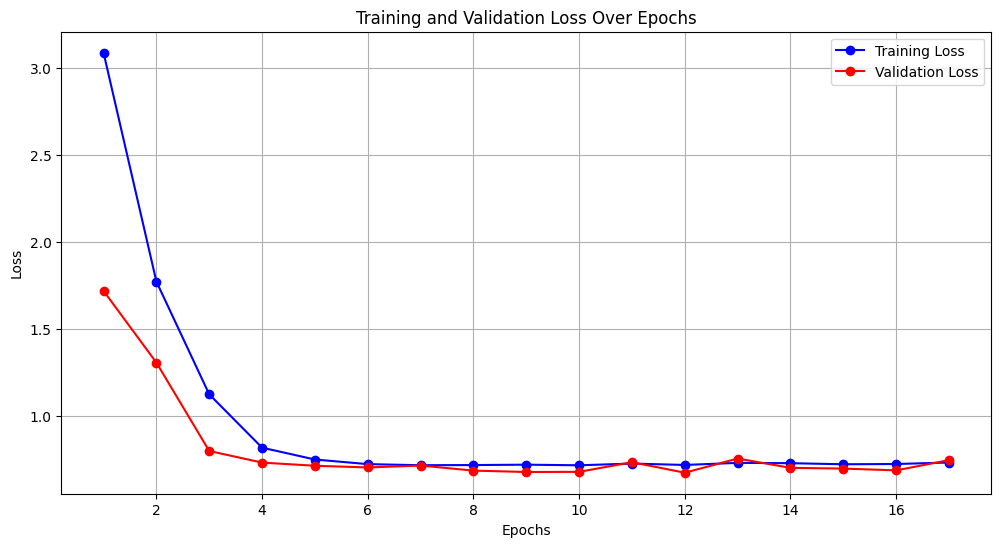

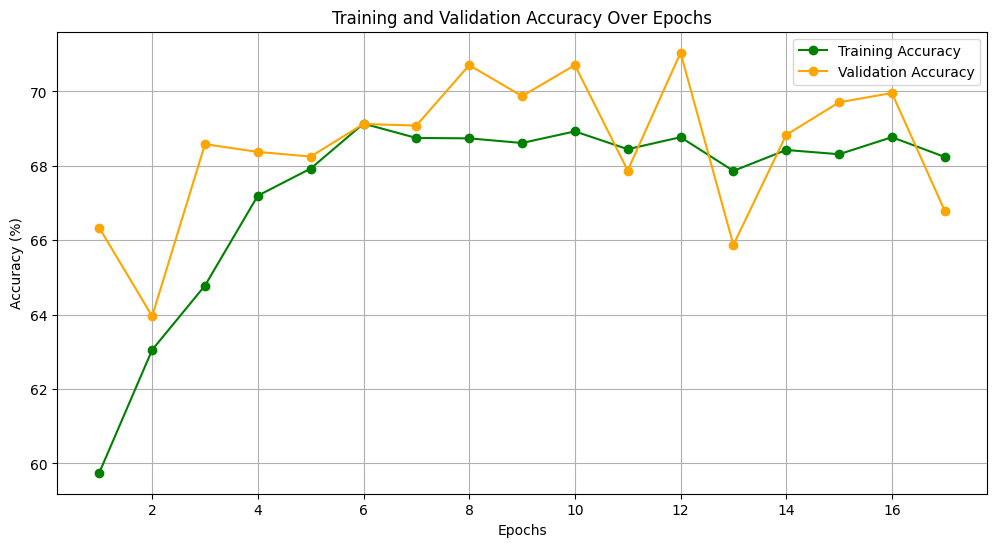

In [67]:
epochs = list(range(1, 18))

train_loss = [
    3.085242592891057, 1.7717639688650768, 1.1244124115506808, 
    0.818381362259388, 0.7503866604963938, 0.7238479507962863, 
    0.7175779055555661, 0.7185831437508265, 0.7206691214442253, 
    0.7172071186701456, 0.7270016810297966, 0.7191025792558988, 
    0.731137088239193, 0.7293181862433752, 0.7230210760235787, 
    0.724562391837438, 0.7331813544034957
]

val_loss = [
    1.7182398732503255, 1.3065967321395875, 0.7992962241172791, 
    0.7327058899402619, 0.7145514996846517, 0.7048227039972941, 
    0.7157631973425548, 0.6866678500175476, 0.6787099889914194, 
    0.679600518544515, 0.735024079879125, 0.6745354525248209, 
    0.7559459217389425, 0.7025452570120494, 0.69833225329717, 
    0.6879908112684886, 0.7468936737378439
]

train_acc = [
    59.75, 63.052083333333336, 64.78125, 67.19791666666667, 
    67.92708333333333, 69.13541666666667, 68.75, 68.73958333333333, 
    68.61458333333333, 68.92708333333333, 68.44791666666667, 
    68.77083333333333, 67.86458333333333, 68.42708333333333, 
    68.3125, 68.77083333333333, 68.23958333333333
]

val_acc = [
    66.33333333333333, 63.958333333333336, 68.58333333333333, 
    68.375, 68.25, 69.125, 69.08333333333333, 70.70833333333333, 
    69.875, 70.70833333333333, 67.875, 71.04166666666667, 
    65.875, 68.83333333333333, 69.70833333333333, 69.95833333333333, 
    66.79166666666667
]

# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', color='green', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### VGG16 (Last FCNN Replaced with a CNN + Cosine Annealing)

In [25]:
# defining the custom convolutional block
class CustomConvBlock(nn.Module):
    def __init__(self):
        super(CustomConvBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # output: 16x32x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # output: 16x16x16
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # output: 32x16x16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # output: 32x8x8
            nn.Flatten()
        )

    def forward(self, x):
        return self.conv_block(x)

# defining a custom VGG16 model
class CustomVGG16(nn.Module):
    def __init__(self):
        super(CustomVGG16, self).__init__()
        # Load the pre-trained VGG16 model
        vgg16 = models.vgg16(pretrained=True)
        
        # Replace the convolutional layers with the custom convolution block
        self.features = CustomConvBlock()
        
        # Replacing the fully connected layers with a new classifier
        # The input to the classifier will be from the output of the custom convolution block (32 * 8 * 8)
        self.classifier = nn.Sequential(
            nn.Linear(32 * 8 * 8, 3)  # Output layer for 3 classes (dog, cat, bird)
        )
    
    def forward(self, x):
        x = self.features(x)  # Get the feature maps from the custom conv block
        x = self.classifier(x)  # Pass through the classifier
        return x

# instantiate the model
model = CustomVGG16()

# freeze all the parameters except for the custom layers
for param in model.parameters():
    param.requires_grad = False

# only train the classifier layers
for param in model.classifier.parameters():
    param.requires_grad = True

# defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

# Cosine Annealing scheduler (with max learning rate and number of epochs)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0

# training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # Training step
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {100*correct/total}%")

    # evaluating on the validation set to check for early stopping
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss}, Validation Accuracy: {100 * correct_val / total_val}%")

    # early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset the counter since validation loss improved
        # Saving the best model so far
        torch.save(model.state_dict(), "vgg16_dog_cat_bird_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
            break

    # updating the learning rate using Cosine Annealing Scheduler
    scheduler.step()

# evaluating the model on the validation set after training
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Validation Accuracy: {100 * correct / total}%")

Epoch 1/50, Loss: 0.9936165744066239, Accuracy: 51.166666666666664%
Validation Loss: 0.9722839562098186, Validation Accuracy: 51.666666666666664%
Epoch 2/50, Loss: 0.9189207357168198, Accuracy: 57.114583333333336%
Validation Loss: 0.9171346775690714, Validation Accuracy: 57.208333333333336%
Epoch 3/50, Loss: 0.8888537462552388, Accuracy: 58.916666666666664%
Validation Loss: 0.9104048593839009, Validation Accuracy: 57.166666666666664%
Epoch 4/50, Loss: 0.8714200460910797, Accuracy: 60.197916666666664%
Validation Loss: 0.8981242577234904, Validation Accuracy: 58.916666666666664%
Epoch 5/50, Loss: 0.8591050108273824, Accuracy: 60.520833333333336%
Validation Loss: 0.9210663199424743, Validation Accuracy: 55.791666666666664%
Epoch 6/50, Loss: 0.8490462481975556, Accuracy: 61.458333333333336%
Validation Loss: 0.8834286610285441, Validation Accuracy: 59.375%
Epoch 7/50, Loss: 0.840451517701149, Accuracy: 62.083333333333336%
Validation Loss: 0.886669724782308, Validation Accuracy: 60.125%
Epoc

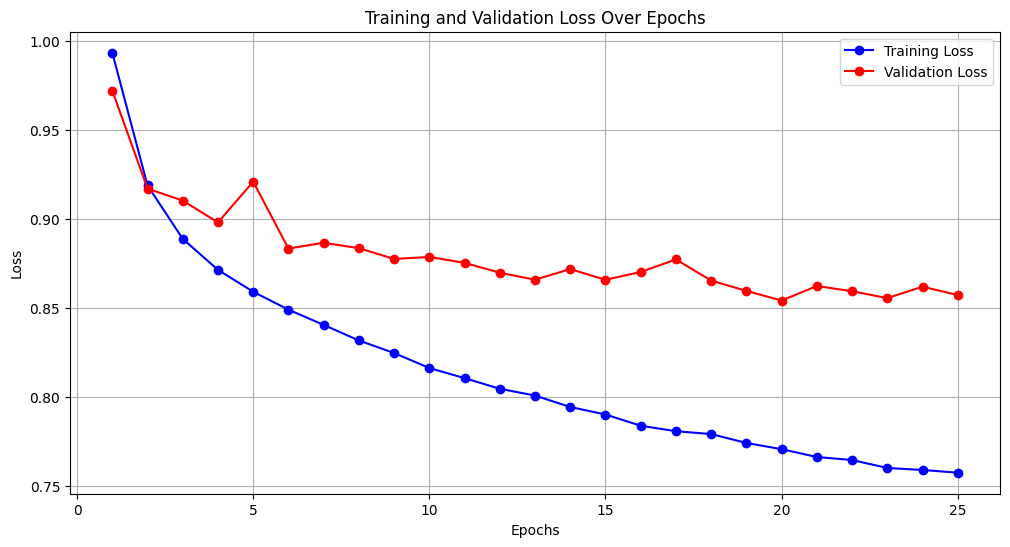

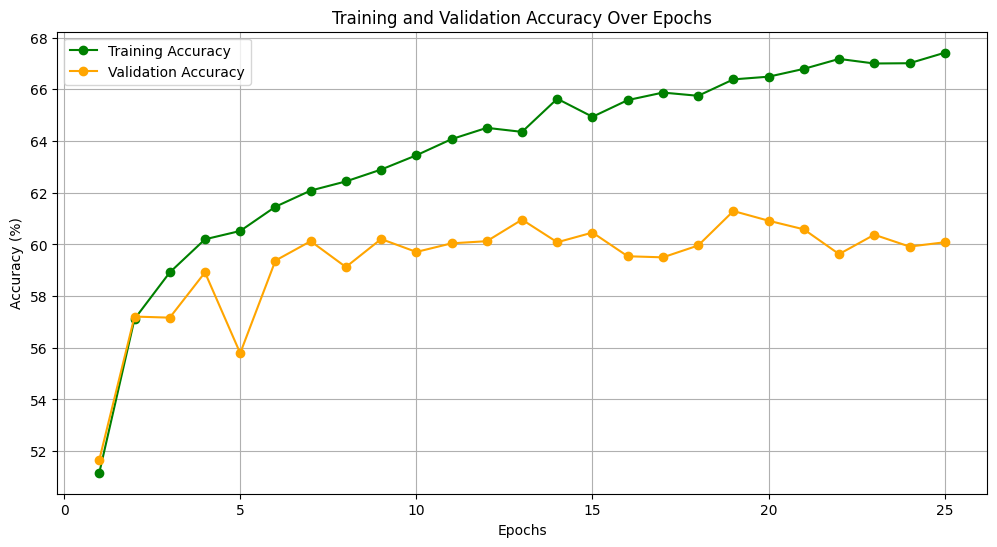

In [68]:
epochs = list(range(1, 26))

train_loss = [
    0.9936165744066239, 0.9189207357168198, 0.8888537462552388, 
    0.8714200460910797, 0.8591050108273824, 0.8490462481975556, 
    0.840451517701149, 0.8316941271225612, 0.8246258662144343, 
    0.8161973303556442, 0.81049107948939, 0.8045214277505874, 
    0.800679966211319, 0.7942725910743078, 0.7900323068102201, 
    0.783730821609497, 0.7806235565741857, 0.779042280515035, 
    0.7740084219972293, 0.7705250269174576, 0.7661265180508295, 
    0.7644235744078954, 0.7599379001061122, 0.7588236397504806, 
    0.7572746427853903
]

val_loss = [
    0.9722839562098186, 0.9171346775690714, 0.9104048593839009, 
    0.8981242577234904, 0.9210663199424743, 0.8834286610285441, 
    0.886669724782308, 0.8836345219612122, 0.8775566975275676, 
    0.87870370388031, 0.8753730630874634, 0.8698230791091919, 
    0.8658835426966349, 0.8718664677937825, 0.8658378561337788, 
    0.8702446945508321, 0.8772844600677491, 0.8654035798708598, 
    0.8595828874905904, 0.8541677737236023, 0.8623255157470703, 
    0.8594083261489868, 0.8555296524365743, 0.8619450346628825, 
    0.8572495683034261
]

train_acc = [
    51.166666666666664, 57.114583333333336, 58.916666666666664, 
    60.197916666666664, 60.520833333333336, 61.458333333333336, 
    62.083333333333336, 62.4375, 62.895833333333336, 63.447916666666664, 
    64.07291666666667, 64.51041666666667, 64.35416666666667, 
    65.63541666666667, 64.9375, 65.58333333333333, 65.875, 65.75, 
    66.38541666666667, 66.48958333333333, 66.79166666666667, 
    67.17708333333333, 67.0, 67.01041666666667, 67.41666666666667
]

val_acc = [
    51.666666666666664, 57.208333333333336, 57.166666666666664, 
    58.916666666666664, 55.791666666666664, 59.375, 60.125, 
    59.125, 60.208333333333336, 59.708333333333336, 60.041666666666664, 
    60.125, 60.958333333333336, 60.083333333333336, 60.458333333333336, 
    59.541666666666664, 59.5, 59.958333333333336, 61.291666666666664, 
    60.916666666666664, 60.583333333333336, 59.625, 60.375, 
    59.916666666666664, 60.083333333333336
]

# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', color='green', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### ResNet18

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
# loading the pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# freezing all the parameters so we can only train the final layer
for param in model.parameters():
    param.requires_grad = False

# modify the classifier layer
model.fc = nn.Linear(model.fc.in_features, 3)

# defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

# early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0

# training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # training step
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {100*correct/total}%")

    # evaluating on the validation set to check for early stopping
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss}, Validation Accuracy: {100 * correct_val / total_val}%")

    # early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset the counter since validation loss improved
        # saving the best model so far
        torch.save(model.state_dict(), "resnet_dog_cat_bird_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
            break

# evaluating the model on the validation set after training
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Validation Accuracy: {100 * correct / total}%")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 175MB/s]


Epoch 1/50, Loss: 0.9716269067923228, Accuracy: 53.822916666666664%
Validation Loss: 0.9335963288942973, Validation Accuracy: 56.333333333333336%
Epoch 2/50, Loss: 0.8871387318770091, Accuracy: 59.166666666666664%
Validation Loss: 0.9023948264122009, Validation Accuracy: 57.75%
Epoch 3/50, Loss: 0.87436838666598, Accuracy: 59.822916666666664%
Validation Loss: 0.8884762303034465, Validation Accuracy: 58.75%
Epoch 4/50, Loss: 0.8761509293317795, Accuracy: 59.947916666666664%
Validation Loss: 0.8796122439702352, Validation Accuracy: 59.291666666666664%
Epoch 5/50, Loss: 0.8623842777808507, Accuracy: 60.28125%
Validation Loss: 0.8998733528455098, Validation Accuracy: 58.416666666666664%
Epoch 6/50, Loss: 0.8717737716436386, Accuracy: 60.96875%
Validation Loss: 0.8789823762575786, Validation Accuracy: 60.083333333333336%
Epoch 7/50, Loss: 0.8655294867356619, Accuracy: 59.989583333333336%
Validation Loss: 0.8827441565195719, Validation Accuracy: 59.583333333333336%
Epoch 8/50, Loss: 0.867914

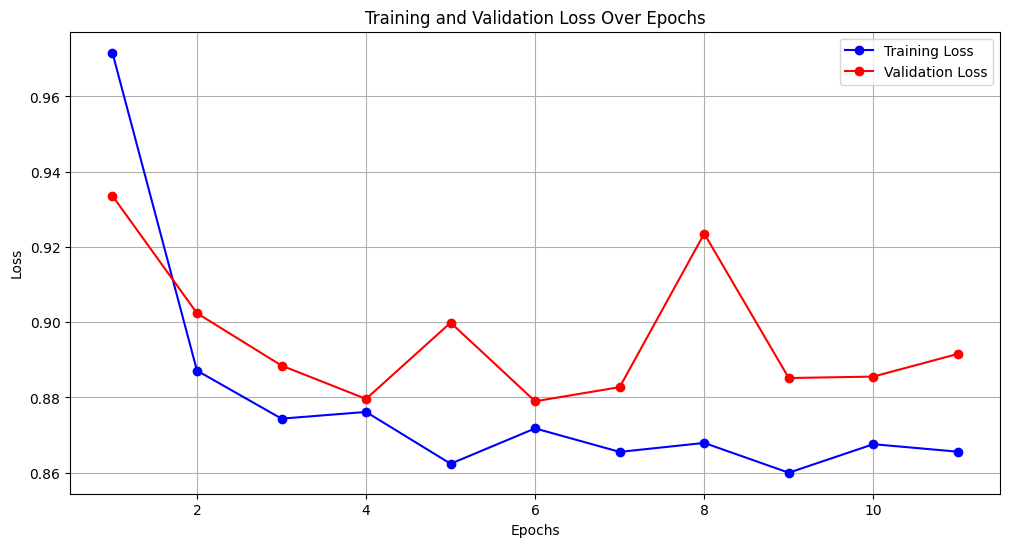

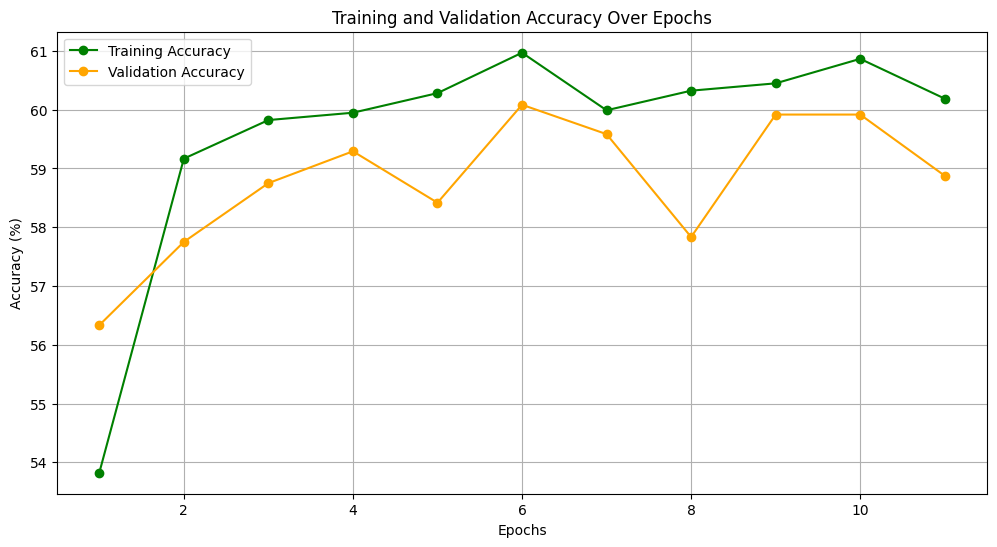

In [69]:
epochs = list(range(1, 12))

train_loss = [
    0.9716269067923228, 0.8871387318770091, 0.87436838666598, 
    0.8761509293317795, 0.8623842777808507, 0.8717737716436386, 
    0.8655294867356619, 0.8679140875736873, 0.8599940931797028, 
    0.8675763736168544, 0.8655859172344208
]

val_loss = [
    0.9335963288942973, 0.9023948264122009, 0.8884762303034465, 
    0.8796122439702352, 0.8998733528455098, 0.8789823762575786, 
    0.8827441565195719, 0.923540731271108, 0.8851574460665385, 
    0.8855488578478495, 0.8915715114275614
]

train_acc = [
    53.822916666666664, 59.166666666666664, 59.822916666666664, 
    59.947916666666664, 60.28125, 60.96875, 59.989583333333336, 
    60.322916666666664, 60.447916666666664, 60.864583333333336, 
    60.1875
]

val_acc = [
    56.333333333333336, 57.75, 58.75, 59.291666666666664, 
    58.416666666666664, 60.083333333333336, 59.583333333333336, 
    57.833333333333336, 59.916666666666664, 59.916666666666664, 
    58.875
]

# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', color='green', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### ResNet (Cosine Annealing)

In [28]:
# loading the pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# freezing all the parameters so we can only train the final layer
for param in model.parameters():
    param.requires_grad = False

# modifying the classifier (fully connected) layer for our specific task
model.fc = nn.Linear(model.fc.in_features, 3)

# defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

# Cosine Annealing scheduler (with max learning rate and number of epochs)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0

# training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # training step
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Accuracy: {100*correct/total}%")

    # evaluating on the validation set to check for early stopping
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss}, Validation Accuracy: {100 * correct_val / total_val}%")

    # early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset the counter since validation loss improved
        # saving the best model so far
        torch.save(model.state_dict(), "resnet_dog_cat_bird_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
            break

    # Update learning rate using Cosine Annealing Scheduler
    scheduler.step()

# evaluating the model on the validation set after training
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Validation Accuracy: {100 * correct / total}%")

Epoch 1/50, Loss: 0.9587203625837962, Accuracy: 54.90625%
Validation Loss: 0.9215399130185445, Validation Accuracy: 58.125%
Epoch 2/50, Loss: 0.8825896241267522, Accuracy: 59.385416666666664%
Validation Loss: 0.8868470978736878, Validation Accuracy: 59.083333333333336%
Epoch 3/50, Loss: 0.8732189440727234, Accuracy: 59.71875%
Validation Loss: 0.8888318030039469, Validation Accuracy: 58.75%
Epoch 4/50, Loss: 0.8683537391821543, Accuracy: 59.895833333333336%
Validation Loss: 0.8814933005968729, Validation Accuracy: 59.625%
Epoch 5/50, Loss: 0.866921759446462, Accuracy: 60.53125%
Validation Loss: 0.8990960256258647, Validation Accuracy: 58.375%
Epoch 6/50, Loss: 0.8643981186548869, Accuracy: 60.739583333333336%
Validation Loss: 0.8679140305519104, Validation Accuracy: 60.666666666666664%
Epoch 7/50, Loss: 0.8651005061467488, Accuracy: 60.645833333333336%
Validation Loss: 0.8859749515851338, Validation Accuracy: 60.083333333333336%
Epoch 8/50, Loss: 0.8641230583190918, Accuracy: 60.1770833

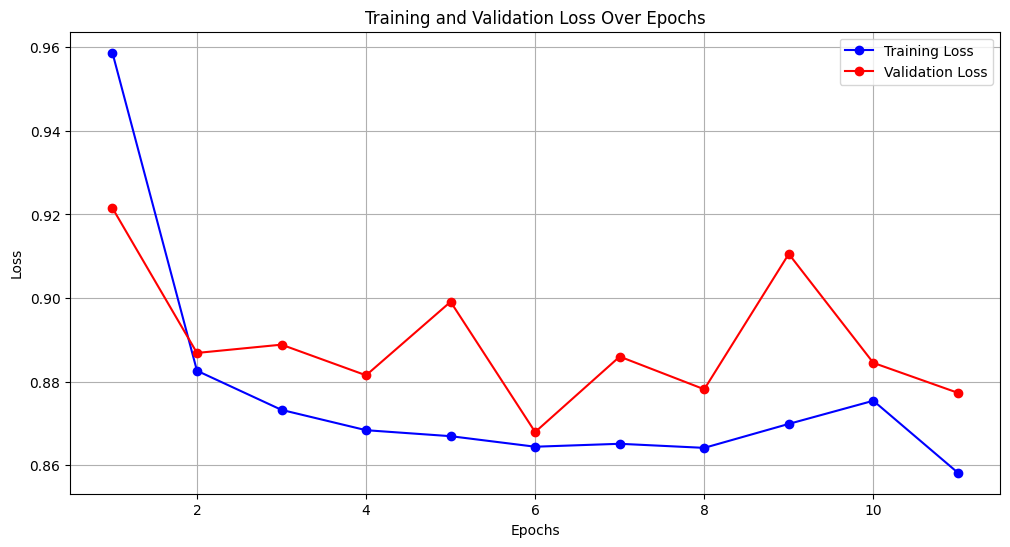

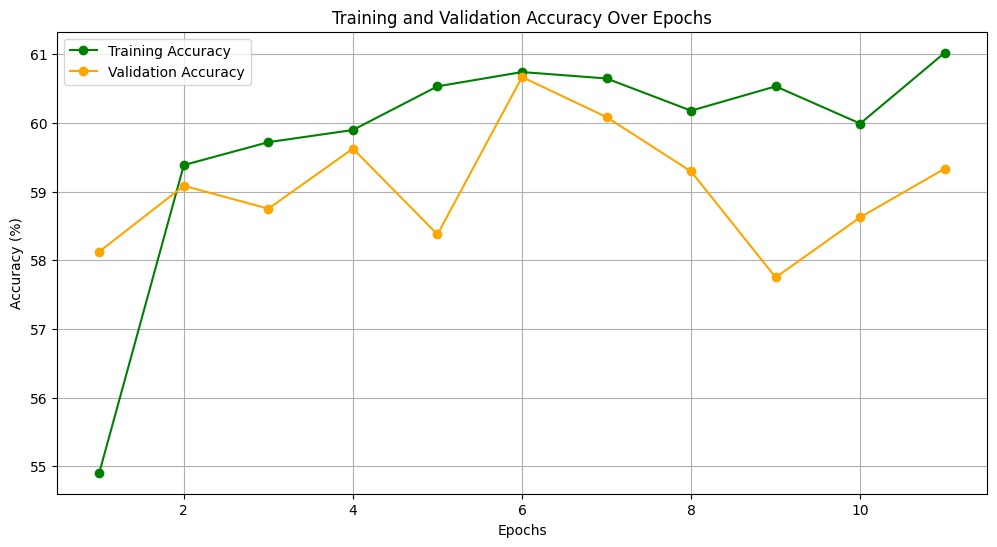

In [70]:
epochs = list(range(1, 12))

train_loss = [
    0.9587203625837962, 0.8825896241267522, 0.8732189440727234, 
    0.8683537391821543, 0.866921759446462, 0.8643981186548869, 
    0.8651005061467488, 0.8641230583190918, 0.8698606262604396, 
    0.8754043606917064, 0.8581729859113694
]

val_loss = [
    0.9215399130185445, 0.8868470978736878, 0.8888318030039469, 
    0.8814933005968729, 0.8990960256258647, 0.8679140305519104, 
    0.8859749515851338, 0.8781465713183085, 0.9105481282869975, 
    0.8844741137822469, 0.877302299340566
]

train_acc = [
    54.90625, 59.385416666666664, 59.71875, 59.895833333333336, 
    60.53125, 60.739583333333336, 60.645833333333336, 60.177083333333336, 
    60.53125, 59.989583333333336, 61.020833333333336
]

val_acc = [
    58.125, 59.083333333333336, 58.75, 59.625, 58.375, 60.666666666666664, 
    60.083333333333336, 59.291666666666664, 57.75, 58.625, 59.333333333333336
]

# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', color='green', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### ResNet18 (ADAM + 30% Dropouts + 0.01 Weight Decay + Batch Normalization)

In [47]:
# loading pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# freezing all layers
for param in model.parameters():
    param.requires_grad = False

# modifying the fully connected layer to match the number of classes (3 classes: dog, cat, bird)
model.fc = nn.Linear(model.fc.in_features, 3)

# adding Dropout and Batch Normalization to the classifier
model.fc = nn.Sequential(
    nn.BatchNorm1d(model.fc.in_features),
    nn.Dropout(0.3),
    model.fc
)

# moving model to device
model = model.to(device)

# defining loss function
criterion = nn.CrossEntropyLoss()

# defining optimizer with Adam and weight decay for regularization
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=0.01)

# Cosine Annealing scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0

# training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # training step
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_acc:.2f}%")

    # evaluating on the validation set to check for early stopping
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    # early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset the counter since validation loss improved
        # Save the best model so far
        torch.save(model.state_dict(), "resnet18_dog_cat_bird_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
            break

    # updating the learning rate using Cosine Annealing Scheduler
    scheduler.step()

# evaluating the model on the validation set after training
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Validation Accuracy: {100 * correct / total}%")

Epoch 1/50, Loss: 0.9605, Accuracy: 53.49%
Validation Loss: 0.8977, Validation Accuracy: 58.58%
Epoch 2/50, Loss: 0.8924, Accuracy: 58.18%
Validation Loss: 0.8919, Validation Accuracy: 59.17%
Epoch 3/50, Loss: 0.8842, Accuracy: 58.53%
Validation Loss: 0.8880, Validation Accuracy: 59.75%
Epoch 4/50, Loss: 0.8851, Accuracy: 59.16%
Validation Loss: 0.8898, Validation Accuracy: 60.08%
Epoch 5/50, Loss: 0.8907, Accuracy: 58.61%
Validation Loss: 0.8972, Validation Accuracy: 59.42%
Epoch 6/50, Loss: 0.8925, Accuracy: 59.15%
Validation Loss: 0.8959, Validation Accuracy: 59.71%
Epoch 7/50, Loss: 0.8960, Accuracy: 58.90%
Validation Loss: 0.9009, Validation Accuracy: 58.92%
Epoch 8/50, Loss: 0.8935, Accuracy: 58.73%
Validation Loss: 0.8982, Validation Accuracy: 59.58%
Early stopping triggered. Stopping training at epoch 8.
Final Validation Accuracy: 59.583333333333336%


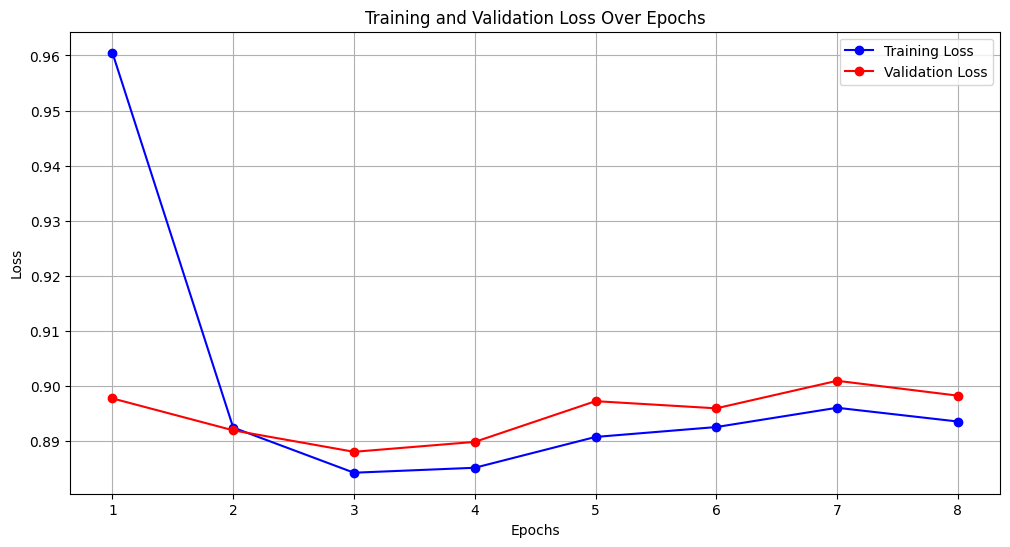

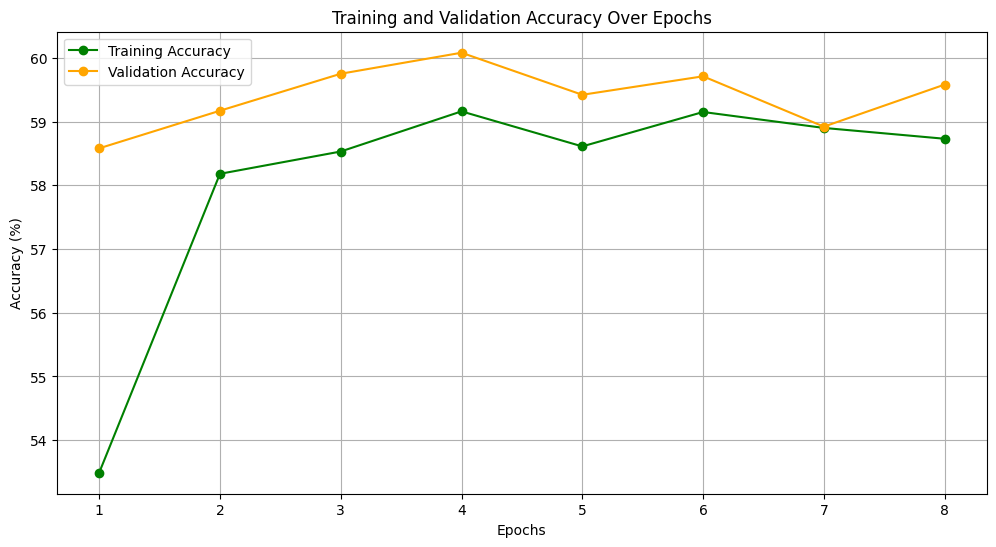

In [71]:
epochs = list(range(1, 9))

train_loss = [
    0.9605, 0.8924, 0.8842, 0.8851, 0.8907, 0.8925, 0.8960, 0.8935
]

val_loss = [
    0.8977, 0.8919, 0.8880, 0.8898, 0.8972, 0.8959, 0.9009, 0.8982
]

train_acc = [
    53.49, 58.18, 58.53, 59.16, 58.61, 59.15, 58.90, 58.73
]

val_acc = [
    58.58, 59.17, 59.75, 60.08, 59.42, 59.71, 58.92, 59.58
]

# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', color='green', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [48]:
# loading pre-trained ResNet50 model
model = models.resnet50(pretrained=True)

# freezing all layers
for param in model.parameters():
    param.requires_grad = False

# modifying the fully connected layer to match the number of classes
model.fc = nn.Linear(model.fc.in_features, 3)

# adding Dropout and Batch Normalization to the classifier
model.fc = nn.Sequential(
    nn.BatchNorm1d(model.fc.in_features),
    nn.Dropout(0.3),
    model.fc
)

# moving model to device
model = model.to(device)

# defining loss function
criterion = nn.CrossEntropyLoss()

# defining optimizer with Adam and weight decay for regularization
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=0.01)

# Cosine Annealing scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0

# training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # training step
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_acc:.2f}%")

    # evaluating on the validation set to check for early stopping
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    # early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset the counter since validation loss improved
        # Save the best model so far
        torch.save(model.state_dict(), "resnet50_dog_cat_bird_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
            break

    # updating the learning rate using Cosine Annealing Scheduler
    scheduler.step()

# evaluating the model on the validation set after training
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Validation Accuracy: {100 * correct / total}%")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 205MB/s]


Epoch 1/50, Loss: 0.9748, Accuracy: 54.62%
Validation Loss: 0.9089, Validation Accuracy: 60.04%
Epoch 2/50, Loss: 0.8813, Accuracy: 59.83%
Validation Loss: 0.8623, Validation Accuracy: 62.00%
Epoch 3/50, Loss: 0.8640, Accuracy: 60.51%
Validation Loss: 0.8572, Validation Accuracy: 61.50%
Epoch 4/50, Loss: 0.8558, Accuracy: 61.12%
Validation Loss: 0.8649, Validation Accuracy: 61.08%
Epoch 5/50, Loss: 0.8601, Accuracy: 61.82%
Validation Loss: 0.8768, Validation Accuracy: 61.79%
Epoch 6/50, Loss: 0.8763, Accuracy: 60.98%
Validation Loss: 0.8823, Validation Accuracy: 61.33%
Epoch 7/50, Loss: 0.8768, Accuracy: 61.36%
Validation Loss: 0.8825, Validation Accuracy: 61.08%
Epoch 8/50, Loss: 0.8791, Accuracy: 60.84%
Validation Loss: 0.8860, Validation Accuracy: 60.96%
Early stopping triggered. Stopping training at epoch 8.
Final Validation Accuracy: 60.958333333333336%


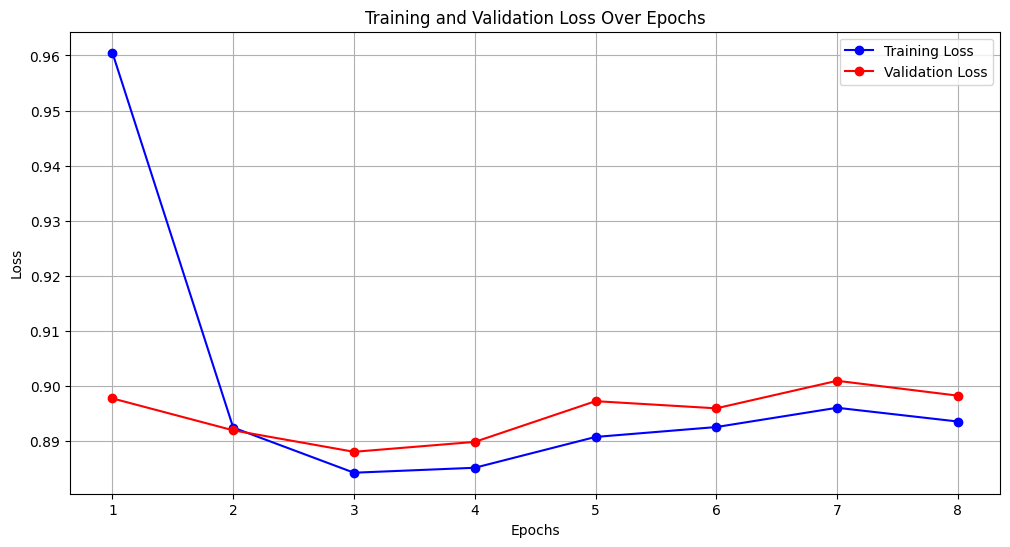

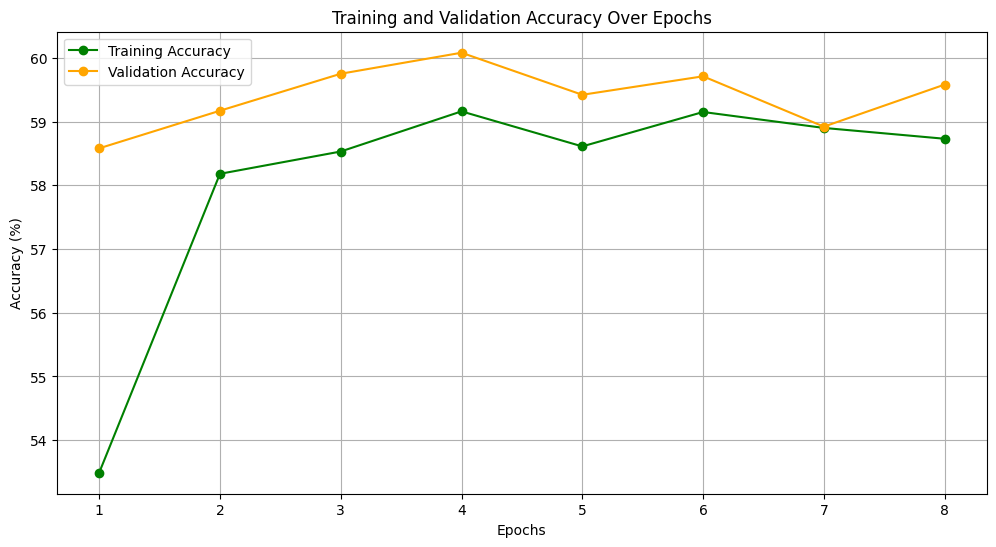

In [72]:
epochs = list(range(1, 9))

train_loss = [
    0.9605, 0.8924, 0.8842, 0.8851, 0.8907, 0.8925, 0.8960, 0.8935
]

val_loss = [
    0.8977, 0.8919, 0.8880, 0.8898, 0.8972, 0.8959, 0.9009, 0.8982
]

train_acc = [
    53.49, 58.18, 58.53, 59.16, 58.61, 59.15, 58.90, 58.73
]

val_acc = [
    58.58, 59.17, 59.75, 60.08, 59.42, 59.71, 58.92, 59.58
]

# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', color='green', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### ResNet50 (30% Dropouts + Weight Decay + Batch Normalization)

In [49]:
# loading pre-trained ResNet50 model
model = models.resnet50(pretrained=True)

# freezing all layers
for param in model.parameters():
    param.requires_grad = False

# modifying the fully connected layer to match the number of classes
model.fc = nn.Linear(model.fc.in_features, 3)

# adding Dropout and Batch Normalization to the classifier
model.fc = nn.Sequential(
    nn.BatchNorm1d(model.fc.in_features),
    nn.Dropout(0.3),
    model.fc
)

# moving model to device (GPU or CPU)
model = model.to(device)

# defining loss function
criterion = nn.CrossEntropyLoss()

# define optimizer with Adam and weight decay for regularization
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001, weight_decay=0.01)

# Cosine Annealing scheduler with specified minimum learning rate
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# early stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0

# training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # training step
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_acc:.2f}%")

    # evaluating on the validation set to check for early stopping
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")

    # early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset the counter since validation loss improved
        # Save the best model so far
        torch.save(model.state_dict(), "resnet50_dog_cat_bird_best.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
            break

    # updating the learning rate using Cosine Annealing Scheduler
    scheduler.step()

# evaluating the model on the validation set after training
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Validation Accuracy: {100 * correct / total}%")

Epoch 1/50, Loss: 0.9725, Accuracy: 54.76%
Validation Loss: 0.9160, Validation Accuracy: 60.04%
Epoch 2/50, Loss: 0.8946, Accuracy: 58.41%
Validation Loss: 0.9048, Validation Accuracy: 60.75%
Epoch 3/50, Loss: 0.8638, Accuracy: 60.71%
Validation Loss: 0.8669, Validation Accuracy: 61.75%
Epoch 4/50, Loss: 0.8494, Accuracy: 61.52%
Validation Loss: 0.8655, Validation Accuracy: 61.42%
Epoch 5/50, Loss: 0.8665, Accuracy: 61.49%
Validation Loss: 0.8936, Validation Accuracy: 60.04%
Epoch 6/50, Loss: 0.8682, Accuracy: 61.52%
Validation Loss: 0.8781, Validation Accuracy: 61.67%
Epoch 7/50, Loss: 0.8754, Accuracy: 61.31%
Validation Loss: 0.8897, Validation Accuracy: 60.33%
Epoch 8/50, Loss: 0.8763, Accuracy: 61.22%
Validation Loss: 0.8845, Validation Accuracy: 60.71%
Epoch 9/50, Loss: 0.8825, Accuracy: 60.28%
Validation Loss: 0.8901, Validation Accuracy: 60.50%
Early stopping triggered. Stopping training at epoch 9.
Final Validation Accuracy: 60.5%


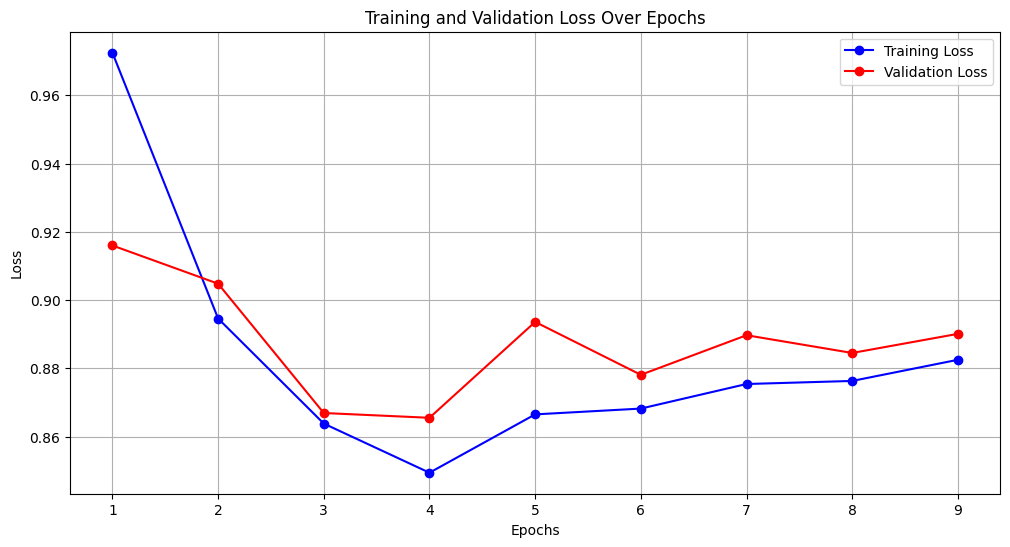

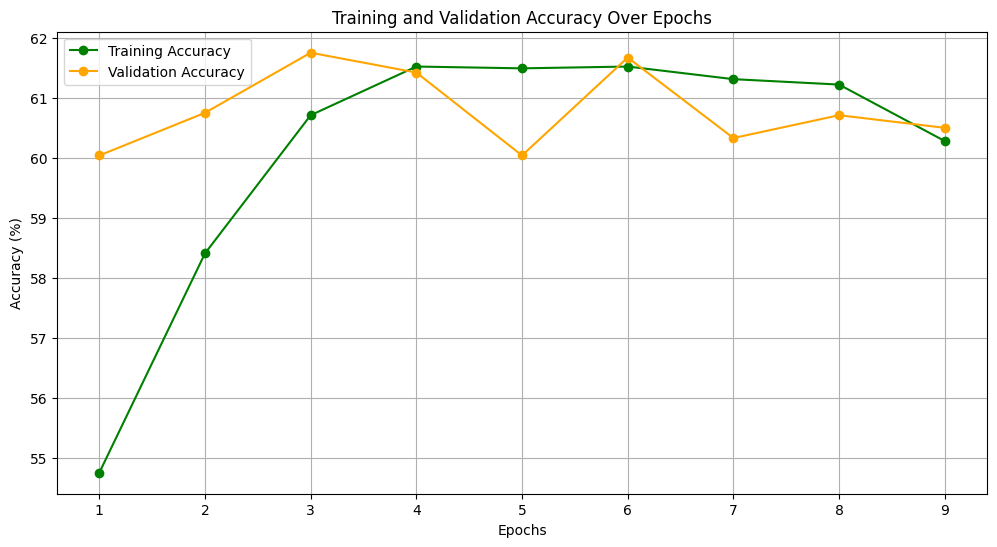

In [73]:
epochs = list(range(1, 10))

train_loss = [
    0.9725, 0.8946, 0.8638, 0.8494, 0.8665, 0.8682, 0.8754, 0.8763, 0.8825
]

val_loss = [
    0.9160, 0.9048, 0.8669, 0.8655, 0.8936, 0.8781, 0.8897, 0.8845, 0.8901
]

train_acc = [
    54.76, 58.41, 60.71, 61.52, 61.49, 61.52, 61.31, 61.22, 60.28
]

val_acc = [
    60.04, 60.75, 61.75, 61.42, 60.04, 61.67, 60.33, 60.71, 60.50
]

# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', color='red', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting training and validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, label='Training Accuracy', color='green', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='orange', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()